In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import seaborn as sns 
#sns.set(style="darkgrid")
plt.rcParams["font.sans-serif"]=["SimHei"]
plt.rcParams["axes.unicode_minus"]=False


from dateutil.relativedelta import relativedelta
from datetime import datetime as dt
import time

import warnings  
warnings.filterwarnings("ignore")

import sys
import pymysql
from sqlalchemy import create_engine
import json
import datetime 
from datetime import timedelta ,time 

from collections import Counter
from numpy import nan as NA
from dateutil.parser import parse
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import gc
import pandas.core.algorithms as algos
from datetime import datetime
import time
import pickle
from sklearn.model_selection import train_test_split
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from sklearn.metrics import roc_auc_score
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate,cross_val_score
from scipy import stats
from sklearn.cluster import DBSCAN  
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb
from tqdm import tqdm
from sklearn import tree
from sklearn.tree import _tree

import os
import sys
# 获取当前工作目录
current_dir = os.getcwd()
# 将模块所在的目录添加到 sys.path
module_dir = os.path.join(current_dir, '../Class_Model')
sys.path.append(module_dir)
from All_Class import All_Model, Data_Clean, Risk_Data
pd.set_option('display.max_columns', None)
# 实例化All_Model类
all_models = All_Model()
clean = Data_Clean()
risk = Risk_Data()

In [2]:
def query(sql,
          host="rm-wz930e5269fur1ht1mo.mysql.rds.aliyuncs.com",
          user="huangxq",
          password="f_epz6hDmZ0Hzi0OzI0N",
          database = '' ,
          port=3306
         ):   
    conn = pymysql.connect(
        host=host,
        user=user,
        port=port,
        password=password,
        max_allowed_packet=1073741824,
        charset="utf8")
    try:
        df = pd.read_sql(sql, con=conn)
        conn.close()
    except:
        print('error')
        conn.close()
        raise
    return df

# 1.样本数据整理

## 1_11.获取_租后数据

In [3]:
sql = '''-- 租后应收监控  
SELECT  tprm.* 
,om.`status` as 订单状态值
,case om.`status` when  1 then "待支付" when  2 then "待发货" when  3 then "待收货" when  4 then "租赁中" when  5 then "待归还" 
when  6 then "待商家收货" when  7 then "退押中" when  8 then "已完成" when  10 then "已退款" when  11 then "待退押金" when  12 then "待审核" 
when  13 then "订单取消" when  15 then "检测中" when  9999 then "逾期订单" end as  订单状态
,om.order_finish_date as 订单完成时间,om.order_method
,tmu.true_name ,tmu.id_card_num,tmu.mobile 
,tod.product_name

-- 2025.4.29
,cc.name as channel_name_cc         -- 来源渠道
,cc.channel_type_id              -- 渠道id
,pa.name as activity_name        -- 活动名称
,pa.type
,om.order_type
,replace(case when JSON_VALID(tor.decision_result) THEN JSON_EXTRACT(tor.decision_result, '$.tips') end,'"','') as tips  
,replace(case when JSON_VALID(tor.risk) THEN JSON_EXTRACT(tor.risk, '$.is_vip') end,'"','') as is_vip
,replace(case when JSON_VALID(tor.risk) THEN JSON_EXTRACT(tor.risk, '$.status') end,'"','') as status_result

from db_digua_business.t_postlease_receivables_monitoring   tprm 
left join db_digua_business.t_order om on tprm.order_id = om.id
left join  db_digua_business.t_member_user tmu on om.user_id = tmu.id
left join  db_digua_business.t_order_details tod on tprm.order_id = tod.order_id

-- 2025.4.29
left join db_digua_business.t_order_risk tor on om.id = tor.order_id
-- 渠道名称
left join db_digua_business.t_channel cc on om.channel = cc.scene 
-- 活动名称
left join db_digua_business.t_platform_activity pa on om.activity_id = pa.id
;
'''

df_zhys = query(sql)
# (27787, 62)
df_zhys.shape

(46438, 71)

## 1_12. 剔除商家数据

In [4]:
# df_zhys["年"] = df_zhys["下单月份"].str[:4]
# pd.crosstab(dfzh1["商家名称"],dfzh1["年"],margins=True).loc[["北京海鸟窝科技有限公司","深圳优优大数据科技有限公司","租着用电脑数码","苏州蚁诺宝"],:]
# 剔除商家数据
def drop_sj(df_zhys,col1,col2):
    df_zhys.drop(df_zhys[df_zhys[col1]=="深圳优优大数据科技有限公司"].index,inplace=True)
    df_zhys.drop(df_zhys[df_zhys[col1]=="优优2店"].index,inplace=True)
    df_zhys.drop(df_zhys[df_zhys[col1]=="小豚租（代收）"].index,inplace=True)
    df_zhys.drop(df_zhys[df_zhys[col1]=="苏州蚁诺宝"].index,inplace=True)
    df_zhys.drop(df_zhys[df_zhys[col1]=="租着用电脑数码"].index,inplace=True)
    df_zhys.drop(df_zhys[df_zhys[col1]=="北京海鸟窝科技有限公司"].index,inplace=True)

    df_zhys.drop(df_zhys[df_zhys[col1]=="汇客好租"].index,inplace=True)
    df_zhys.drop(df_zhys[df_zhys[col1]=="澄心优租"].index,inplace=True)
    df_zhys.drop(df_zhys[df_zhys[col1]=="CPS渠道合作"].index,inplace=True)
    
    df_zhys.drop(df_zhys[df_zhys[col1]=="趣智数码"].index,inplace=True)
    df_zhys.drop(df_zhys[df_zhys[col1]=="格木木二奢名品"].index,inplace=True)
    df_zhys.drop(df_zhys[df_zhys[col1]=="广州康基贸易有限公司"].index,inplace=True)
    df_zhys.drop(df_zhys[df_zhys[col1]=="线下小店"].index,inplace=True)  # 计划
    df_zhys.drop(df_zhys[df_zhys[col1]=="小蚂蚁租机"].index,inplace=True)  #拒量订单
   

    df_zhys.drop(df_zhys[df_zhys[col2].str.contains(pat='探路者',regex=False)==True].index,inplace=True)
    df_zhys.drop(df_zhys[df_zhys['merchant_name'] == "乙辉数码"].index, inplace=True)
    return df_zhys

df_zhys = drop_sj(df_zhys,'merchant_name','model_number')
df_zhys.shape

(43745, 71)

## 1_13.历史订单渠道名称补充

In [5]:
# 1148 条历史订单渠道名称补充
qudao_name_df = pd.read_excel('F:/myfile/租后数据/历史订单渠道名称补充.xlsx')
qudao_name_df.drop(columns=['渠道id','下单时间'],inplace = True)

# dfzh1 = df_zh.merge(qudao_name_df,on = '订单号',how = 'left')
dfzh1 =  df_zhys.merge(qudao_name_df,left_on = 'order_number',right_on = '订单号',how = 'left')
# dfzh1.columns

# qudao_name_df.shape
# qudao_name_df[:2]
# qudao_name_df['渠道名称'].value_counts()

# 渠道名称缺失补充
# dfzh1["渠道名称"] = dfzh1["渠道名称_x"].fillna(dfzh1.渠道名称_y)
dfzh1["channel_name"] = np.where(dfzh1.渠道名称.notnull(), dfzh1.渠道名称, dfzh1["channel_name"])
# dfzh1["channel_name"].isnull().sum()

# dfzh1[['order_number','channel_name','渠道名称']][:10]
# df_zhys[df_zhys['order_number'] == 'A202207131230485'][['order_number','channel_name']]

# 更新渠道，同时给客群打标签
# 2025.4.29
# 是否巨量、是否号卡
# df =  df.merge(qudao_name_df,left_on = 'order_number',right_on = '订单号',how = 'left')
# dfzh1["channel_name_cc"] = np.where(dfzh1.渠道名称.notnull(), dfzh1.渠道名称, dfzh1["channel_name_cc"])
dfzh1.loc[:,"来源渠道"]=dfzh1["channel_name"].fillna("未知渠道")
dfzh1.loc[:,"归属渠道"]=dfzh1.apply(lambda x: clean.qudao_type(x["来源渠道"],x["activity_name"],x["order_method"], x['channel_type_id'], x['order_type']),axis=1)
dfzh1['归属渠道'] = np.where(dfzh1.归属渠道 == '顶部搜索框的搜索结果页', '搜索渠道', dfzh1.归属渠道)
# conditions_1 = ['租机宝','八派信息','CPS直播','派金花','富士康租机','九州信息','勉丫租','哈银','租瓜直播','美仑美奂','兔丫租赁','分期乐1','分期乐2','98租超','邦客惠乘车码','推一推','硬派抖音']
conditions_1 = ['八派信息','CPS直播','派金花','九州信息','勉丫租','哈银','租瓜直播','美仑美奂','分期乐1','分期乐2','98租超','推一推','硬派抖音']
dfzh1['归属渠道'] = np.where(dfzh1.归属渠道.isin(conditions_1), 'S量', dfzh1.归属渠道)


# dfzh1[dfzh1.归属渠道 == '顶部搜索框的搜索结果页']，channel_name 为 顶部搜索框的搜索结果页，channel_name_cc 为 空，下单日期为 2023-03 及之前
# A20250113184842199 channel_name为 顶部搜索框的搜索结果页， channel_name_cc 为顶部搜索框的搜索结果页，归属渠道 为抖音

dfzh1['是否免人审'] = np.where((dfzh1.is_vip=='1')&(dfzh1.status_result=='0'), 1 , 0)

# df['是否拒量'] = np.where(df.qvt_risk == '1', 1 , 0)
# df['是否拒量'] = np.where((df.qvt_risk == '0') & (df.qvt_result == '1'), 1 , df.是否拒量)
dfzh1['是否拒量'] = np.where(dfzh1.tips.str.contains(r'策略2412|命中自有模型回捞策略|回捞策略250330命中')==True, 1, 0)
dfzh1['是否号卡'] = np.where(dfzh1.type == 4, 1, 0)

# df_zhys.columns
# df_zhys[['channel_name','channel_name_cc']]
# df_zhys.channel_name.value_counts()
# df_zhys.channel_name_cc.value_counts()
# 芝麻信用 芝麻租物 

# dfzh1[dfzh1.order_number == 'A2023110319165440'][['归属渠道']]

## 1_14.渠道归属

In [6]:
# def qudao_type(a,b,c):
#     a = str(a)
#     b = str(b)
#     if "租物" in b:
#         return "芝麻租物"
#     elif "芝麻" in b:
#         return "芝麻租物"
#     elif "抖音" in b:
#         return "抖音渠道"
#     elif "搜索" in a:
#         return "搜索渠道"
#     elif "租物" in a:
#         return "芝麻租物"
#     elif "芝麻" in a:
#         return "芝麻租物"
#     elif c == 1:
#         return "芝麻租物" 
#     elif "叮咚直播" in a:
#         return "叮咚直播"
#     elif "八派信息" in a:
#         return "八派信息"
#     elif "租瓜直播2号" in a:
#         return "租瓜直播2号"
#     elif "租瓜直播" in a:
#         return "租瓜直播"
#     elif "直播" in a:
#         return "小舞直播"
#     elif "繁星" in a:
#         return "繁星"
#     elif "生活号" in a:
#         return "生活号"
#     elif "社群" in a:
#         return "支付宝社群"
#     elif "付费灯火" in a:
#         return "付费灯火"
#     else :
#         return a

In [7]:
# # df.loc[:,"归属渠道"]=df.apply(lambda x:qudao_type(x["来源渠道"],x["activity_name"],x["order_method"]),axis=1)
# dfzh1["activity_source"] = dfzh1["activity_source"].fillna('未知活动') 
# dfzh1["channel_name"] = dfzh1["channel_name"].fillna('未知渠道') 

# dfzh1.loc[:,"归属渠道"]=dfzh1.apply(lambda x:qudao_type(x["channel_name"],x["activity_source"],x["order_method"]),axis=1)

# # pd.crosstab(dfzh1["下单月份"],dfzh1["归属渠道"],margins=True)

## 1_15.判断颜色 内存

In [8]:
dfzh1["内存"]=dfzh1["specification"].str.split("内存：").str[1].str.split("颜色：").str[0].str.split(" ").str[0]
# dfzh1["内存"].value_counts()[14:]

dfzh1["颜色"]=dfzh1["specification"].str.split("内存：").str[1].str.split("颜色：").str[1].str.split(" ").str[0]
# dfzh1["颜色"].value_counts()[1:10]

## 1_16.判断二手、带锁

In [9]:
# dfzh1['是否二手'] = np.where(dfzh1['model_number'].str.contains('95新')|dfzh1['model_number'].str.contains('99新')|dfzh1['model_number'].str.contains('准新'),"二手","全新")
# note 20241124 修改口径，用product_name判断是否二手
dfzh1['是否二手'] = np.where(dfzh1['product_name'].str.contains('95新')|dfzh1['product_name'].str.contains('99新')|dfzh1['product_name'].str.contains('准新'),"二手","全新")
dfzh1['是否二手'].value_counts()

是否二手
全新    42557
二手     1188
Name: count, dtype: int64

In [10]:
#读取导入最新出库台账数据,2023.9及以后的数据
# （1）512 带锁
# （2）非512的多头带锁
# （3）抖音带锁
# note 20241204
# （1）512 带锁，但每天豁免一台 512P 不带锁，目前还没量
# （2）非512的命中多头提示带锁，但出库是否带锁由人工控制
# （3）抖音带锁（苹果11-15）
# 维客壹佰2023&2024年台账1204.xlsz 为截止到20241203的数据
# f_path_ck = "维客壹佰2023&2024年台账1204.xlsx"
f_path_ck = "维客壹佰2023&2024年台账.xlsx"
path = 'F:/myfile/p站数据/台账数据/'
dfck = pd.read_excel(path + f_path_ck,sheet_name="2023")   #,skiprows=0 header 

# dfck['是否带锁']  = np.where((dfck['型号'].str.contains(r'带锁|有锁'))|(dfck['内存']=='512G')|(dfck['内存']=='512GB'), 1, 0)
dfck['是否带锁']  = np.where((dfck['型号'].str.contains(r'带锁|有锁'))|(dfck['内存'].str.contains(r'512')), '带锁', '未带锁')
dfck = dfck[[u'订单号',u'是否带锁']]
dfck.shape
dfck['是否带锁'].value_counts()

dfck.drop_duplicates(subset=["订单号"],inplace=True)

# 合并到主表中去
# dfck 的带锁不一定出库，dfzh1 是出库的
dfck = dfck.rename(columns= {'订单号': 'order_number'})
dfzh1 = dfzh1.merge(dfck, on = 'order_number', how = 'left')
dfzh1['是否带锁'] = dfzh1['是否带锁'].fillna('未带锁') 
dfzh1.shape

pd.pivot_table(dfzh1,index='是否二手',columns='是否带锁',values='order_id',aggfunc='count')

(39581, 2)

是否带锁
未带锁    36590
带锁      2991
Name: count, dtype: int64

(43745, 82)

是否带锁,带锁,未带锁
是否二手,,
二手,503,685
全新,2140,40417


## 1_17.日期处理

In [11]:
dfzh1["下单日期"] = dfzh1['order_create_time'].dt.date
dfzh1["下单日期"] = pd.to_datetime(dfzh1["下单日期"],errors="coerce")
dfzh1["下单日期"].head()

dfzh1["月份"]=dfzh1["下单日期"].dt.month
dfzh1["年份"]=dfzh1["下单日期"].dt.year
# df_total["下单月份"].value_counts()

0   2022-07-05
1   2022-07-13
2   2022-07-15
3   2022-07-16
4   2022-07-17
Name: 下单日期, dtype: datetime64[ns]

In [12]:
def getjidu(s):
    if s<4:
        return "1季度"
    elif 4<=s<7:
        return "2季度"
    elif 7<=s<10:
        return "3季度"
    else:
        return "4季度"
dfzh1["季度"]= dfzh1.apply(lambda x:getjidu(x["月份"]),axis=1)  
dfzh1["季度"].value_counts()

季度
2季度    13375
4季度    11213
3季度     9679
1季度     9478
Name: count, dtype: int64

## 1_21.获取_买断数据

In [13]:
sql1 = ''' --   买断信息 
with out_order as ( 
SELECT too.order_id,too.`status` 
,too.real_pay_money ,too.create_time,too.update_time
,too.pay_date ,too.actual_money 
,rank() over(partition by too.order_id order by too.pay_date desc) as rn 
from db_digua_business.t_order_out too
where  too.`status` not in (1)   -- 买断状态：1 未买断 2 已买断  3 部分买断 
-- and too.pay_status= 2    -- '支付状态 1、待支付 2、已支付 3、退款中 4、已退款 6、支付取消 7、已关闭',
-- GROUP BY 1 ,2
-- ORDER BY 5 desc,1
)
# note 20241126 增加distinct，买断可能分多次付款
# 181950     2
# 338547     2
# 1083822    2
# 303756     2
SELECT distinct t1.*
,t2.`status`
,case when t2.`status`=2 then '已买断' when  t2.`status`=3 and om.order_finish_date is not null then '已买断'  else '部分买断' end as if_outpay 
,om.order_finish_date
,case when t2.`status`=2 and om.order_finish_date is null then t1.pay_date else om.order_finish_date end as finish_date_new 
from (
SELECT too.order_id  -- ,too.`status` 
-- ,count(DISTINCT too.`status`) nn 
,sum(too.real_pay_money) as outpay_money     -- ,max(too.update_time) as outpay_time
,max(too.pay_date) as pay_date 
from out_order  too
GROUP BY 1 -- ,2
ORDER BY 2 desc ,1) t1 
left join out_order t2 on t1.order_id = t2.order_id and t2.rn=1 
left join db_digua_business.t_order om on t1.order_id = om.id 
;
'''

df_out = query(sql1)
df_out.shape

(4830, 7)

## 1_22.租后数据 关联 买断数据

In [14]:
dfzh2 = dfzh1.merge(df_out[['order_id', 'outpay_money', 'pay_date', 'status', 'if_outpay']], on = 'order_id', how = 'left')
dfzh2.shape
dfzh1.shape

(43745, 90)

(43745, 86)

In [15]:
dfzh2['finish_date_new'] = dfzh2.apply(lambda x:pd.to_datetime(x.pay_date, errors='coerce') if pd.isnull(x.order_finish_date) and x.status==2
                                       else pd.to_datetime(x.订单完成时间, errors='coerce') if pd.isnull(x.order_finish_date)  and pd.notnull(x.订单完成时间)
                                       else pd.to_datetime(x.order_finish_date, errors='coerce'),axis = 1 ) 
# dfzh2['finish_date_new'] = np.where((pd.isnull(dfzh2.order_finish_date)) & (dfzh2.status==2),pd.to_datetime(dfzh2.pay_date, errors='coerce'),pd.to_datetime(dfzh2.order_finish_date, errors='coerce'))
dfzh2['finish_date_new'].notnull().sum()

np.int64(6013)

In [16]:
dfzh2['if_outpay'] = dfzh2.apply(lambda x: '已买断' if x['status'] ==2 
                                 else  '已买断'  if  x['status'] ==3 and pd.notnull(x.finish_date_new) 
                                 else '部分买断' if x['status'] ==3 and pd.isnull(x.finish_date_new) 
                                 else '未知',axis =1)
dfzh2['if_outpay'].value_counts()

if_outpay
未知      39112
已买断      4535
部分买断       98
Name: count, dtype: int64

## 1_31.获取_分期取消数据

In [17]:
sql1 = '''-- 订单分期表  取消的分期
SELECT tos.order_id,count(*) as nn
,count(tos.reality_refund_date) as  reality_refund_date
,sum(tos.real_pay_money) as real_pay_money
,sum(tprm.purchase_amount)/count(tos.order_id) as purchase_amount
,avg(tprm.advance_periods) as  advance_periods
,avg(tprm.advance_sum) as advance_sum
from db_digua_business.t_order_stages tos 
inner join db_digua_business.t_postlease_receivables_monitoring   tprm 
on tos.order_id = tprm.order_id 
# 订单取消
where tos.`status`=4 
GROUP BY 1 order by 2 desc 
;
'''

df_cancel = query(sql1)
df_cancel.shape

(2607, 7)

## 1_32.租后数据关联分期取消数据

In [18]:
dfzh3 = dfzh2.merge(df_cancel[['order_id', 'nn', 'reality_refund_date', 'real_pay_money']],on = 'order_id',how = 'left')
dfzh3.shape
dfzh2.shape

# 不同还款状态下  完成时间的情况
# dfzh3.groupby(['rembursement_status']).agg({'order_id':'count','order_finish_date':'count','订单完成时间':'count','finish_date_new':'count','pay_date':'count','nn':'count','outpay_money':'sum'})

# 不同订单状态下  完成时间的情况
# dfzh3.groupby(['订单状态']).agg({'order_id':'count','order_finish_date':'count','订单完成时间':'count','finish_date_new':'count','pay_date':'count','nn':'count','outpay_money':'sum'})

# 有取消记录的用户分布情况
# dfzh3[dfzh3.nn>=1].groupby(['rembursement_status']).agg({'order_id':'count','order_finish_date':'count','订单完成时间':'count'
                                                        #  ,'finish_date_new':'count','pay_date':'count','nn':'count','real_pay_money':'sum'})

# 有取消记录的用户分布情况
# dfzh3[dfzh3.nn>=1].groupby(['订单状态']).agg({'order_id':'count','order_finish_date':'count','订单完成时间':'count'
                                                        #  ,'finish_date_new':'count','pay_date':'count','nn':'count','real_pay_money':'sum'})

(43745, 94)

(43745, 91)

## 1_41.按风控策略调整时间节点划分时间段

In [19]:
#按风控策略调整时间节点划分时间段
dfzh1.loc[:"2023-01-09","时间段"]=" -2023.1.9前"
dfzh1.loc["2023-01-10":"2023-03-03","时间段"]="2023.1.10-2023.3.3"
dfzh1.loc["2023-03-04":"2023-03-24","时间段"]="2023.3.4-2023.3.24"
dfzh1.loc["2023-03-25":"2023-04-28","时间段"]="2023.3.25-2023.4.28"
dfzh1.loc["2023-04-29":"2023-05-17","时间段"]="2023.4.29-2023.5.17"
dfzh1.loc["2023-05-18":"2023-05-31","时间段"]="2023.5.18-2023.5.31"
dfzh1.loc["2023-06-01":"2023-06-30","时间段"]="2023.6.1-2023.6.30"
dfzh1.loc["2023-07-01":"2023-08-11","时间段"]="2023.7.1-2023.8.11"
dfzh1.loc["2023-08-12":"2023-09-15","时间段"]="2023.8.12-2023.9.15"
dfzh1.loc["2023-09-16":"2023-09-22","时间段"]="2023.9.16-2023.9.22"
dfzh1.loc["2023-09-23":"2023-11-16","时间段"]="2023.9.23-2023.11.16"
dfzh1.loc["2023-11-17":"2023-11-28","时间段"]="2023.11.17-2023.11.28"
dfzh1.loc["2023-11-29":"2023-12-05","时间段"]="2023.11.29-2023.12.5"
dfzh1.loc["2023-12-06":"2024-01-05","时间段"]="2023.12.06-2024.1.5"
dfzh1.loc["2024-01-06":"2024-01-23","时间段"]="2024.1.6-2024.1.23"
dfzh1.loc["2024-01-24":"2024-2-21","时间段"]="2024.1.24-2024.2.21"
dfzh1.loc["2024-02-22":"2024-02-29","时间段"]="2024.2.22-2024.2.29"
dfzh1.loc["2024-03-01":"2024-03-12","时间段"]="2024.3.1-2024.3.12"
dfzh1.loc["2024-03-13":"2024-04-03","时间段"]="2024.3.13-2024.4.3"
dfzh1.loc["2024-04-04":"2024-04-10","时间段"]="2024.4.4-2024.4.10"
dfzh1.loc["2024-04-11":"2024-04-18","时间段"]="2024.4.11-2024.4.18"
dfzh1.loc["2024-04-19":"2024-04-24","时间段"]="2024.4.19-2024.4.24"
dfzh1.loc["2024-04-25":"2024-04-27","时间段"]="2024.4.25-2024.4.27"
dfzh1.loc["2024-04-28":,"时间段"]="2024.4.28- "

## 1_51.获取_账期数据（含续租）

In [20]:
sql_xz = ''' 
-- 状态,1:未支付  2:扣款失败 3:已支付 4：已取消 5、申请扣款、6已退款',
-- '是否续租账期,0非续租账期，1预授权账期，2自定义续租账期',
SELECT ymos.*
from db_rent.ya_merchant_order_stages ymos 
inner join db_digua_business.t_postlease_receivables_monitoring tprm 
on ymos.order_id = tprm.order_id 
;
'''

df_xzfq = query(sql_xz)
df_xzfq.shape

(575594, 23)

In [21]:
# note 20241227 号卡 应付日期更新
# 分期表
sql = '''-- 租后应收监控  
SELECT distinct hk.order_number, tos.order_id, tos.refund_date as refund_date_1
from db_digua_business.t_order_stages tos
inner join
    (select distinct om.id as order_id, om.order_number
    from db_digua_business.t_order om
    left join db_digua_business.t_platform_activity tpa 
    on tpa.id=om.activity_id
    where tpa.type = 4) hk
on tos.order_id = hk.order_id
'''
tmp_hk = query(sql)
tmp_hk['refund_date_ym'] = tmp_hk['refund_date_1'].dt.strftime('%Y-%m')
tmp_hk.shape
tmp_hk[:2]

df_xzfq['refund_date_ym'] = df_xzfq['refund_date'].dt.strftime('%Y-%m')
df_xzfq = df_xzfq.merge(tmp_hk[['order_id', 'refund_date_1', 'refund_date_ym']], on = ['order_id', 'refund_date_ym'], how = 'left')
df_xzfq['refund_date_2'] = np.where(df_xzfq.refund_date_1.notnull(), df_xzfq.refund_date_1, df_xzfq.refund_date)
df_xzfq.shape

df_xzfq.drop(columns=['refund_date_1','refund_date_ym','refund_date'],inplace = True)
df_xzfq = df_xzfq.rename(columns = {'refund_date_2':'refund_date'})
df_xzfq.shape

(4872, 4)

,order_number,order_id,refund_date_1,refund_date_ym
0,A20240927154904302,1533488,2024-09-30,2024-09
1,A20240927154904302,1533488,2024-10-30,2024-10


(575594, 26)

(575594, 23)

In [22]:
# 数据检查
# tmp1 = df_xzfq.drop_duplicates(subset = ['order_id'])[['order_id']]
# tmp2 = tmp_hk.drop_duplicates(subset = ['order_id'])[['order_id', 'order_number']]
# tmp1.shape
# tmp2.shape

# tmp3 = tmp1.merge(tmp2, on = 'order_id', how = 'inner')
# tmp3.shape

# tmp4 = tmp3.merge(df_xzfq, on = 'order_id', how = 'inner')
# tmp4.shape

# tmp4["日"]=tmp4["refund_date"].dt.day
# tmp4["日"].value_counts()
# tmp4[tmp4.日.isin([2,11])][['order_number','refund_date']]

# df_xzfq[df_xzfq.refund_date_2 != df_xzfq.refund_date].shape
# df_xzfq[df_xzfq.refund_date_2 == df_xzfq.refund_date].shape
# df_xzfq[df_xzfq.refund_date_2 != df_xzfq.refund_date][['order_id', 'refund_date', 'refund_date_1', 'refund_date_2', 'refund_date_ym']]
# 以下四个订单的应付日期<15号，订单分期表更正了  正常的订单的应付日期
# A20240929094315174 1539249  已退款
# A2024092919033313  1541755  正常
# A2024092919182056  1541798  已退款
# A2024100810242488  1568606  已退款

# tmp_hk[tmp_hk.order_number.isin(['A2024100810242488'])]
# df_xzfq[df_xzfq.order_id.isin([1539249,1541755,1541798,1568606])][['order_id', 'refund_date', 'refund_date_1', 'refund_date_2', 'refund_date_ym']]

In [23]:
# df_xz_concat[df_xz_concat.order_number.isin(['A2024080919264964','A2024092919033313','A20241218184711224'])][['order_number','应付日期','实付日期','逾期天数']]
# A2024080919264964
# A2024092919033313
# tmp = df_xz_concat[df_xz_concat.逾期天数 > 30].drop_duplicates(subset=['order_number'])[['order_number']]
# tmp = tmp.merge(df_hk, on = 'order_number', how = 'inner')
# tmp.shape
# tmp

## 1_52.重命名

In [24]:
df_xzfq = df_xzfq.rename(columns={'money':'当前应付租金','part_payment':'实付金额','refund_date':'应付日期','reality_refund_date':'实付日期','sort':'当前期数'})

## 1_53.实还金额核查

In [25]:
# total_check = df_ddfq.merge(df_xzfq,on=['订单ID','当前期数'],how='inner')
# total_check.info()

# total_check1= total_check[(total_check.实付金额_y < total_check.实付金额_x)][['订单ID','订单号','应付日期_x','实付日期_x','实付日期_y','实付金额_x','实付金额_y','状态','status']]    #   #(total_check.应付日期_x.notnull()) & (total_check.应付日期_y.isnull())
# total_check1= total_check[(total_check.实付金额 < total_check.实际支付金额)][['订单ID','订单号','还款日期','实际还款日期','实付日期','实际支付金额','实付金额','状态','status']]
# total_check1

# total_check2= total_check[(total_check.实付金额_y > total_check.实付金额_x)][['订单ID','订单号','应付日期_x','实付日期_x','实付日期_y','实付金额_x','实付金额_y','状态','status']]    #   #(total_check.应付日期_x.notnull()) & (total_check.应付日期_y.isnull())
# total_check2= total_check[(total_check.实付金额 > total_check.实际支付金额)][['订单ID','订单号','还款日期','实际还款日期','实付日期','实际支付金额','实付金额','状态','status']]
# total_check2

# total_check2.to_excel('E:/myfile/业务相关数据/total_check_0709-1.xlsx')

## 1_61.数据合并

In [26]:
df_xz_concat = df_xzfq.merge(dfzh3,how='right',on ='order_id')
# df_xz_concat = df_fq.merge(dfzh1,how='right',right_on ='订单id',left_on='订单ID')
# note 20241126 增加
# df_xz_concat[df_xz_concat.当前应付租金.isnull()].shape
# df_xz_concat[df_xz_concat.当前应付租金.isna()].shape
# 实付日期为空，但当前应付租金为空
# 1681669 A20241104144812228
df_xz_concat.实付金额 = df_xz_concat.实付金额 + df_xz_concat.sesame_promo_money_pay + df_xz_concat.promo_money
df_xz_concat = df_xz_concat[df_xz_concat.当前应付租金.notnull()]

# order_id == 1681669 的当前期数为空
# 1681669	A20241104144812228
# 1669581	A2024110109350797
df_xz_concat['当前期数'].notnull().sum()
df_xz_concat.shape
df_xzfq.shape
dfzh3.shape

# df_xz_concat.drop_duplicates(subset=["order_id"]).shape
# dfzh3.drop_duplicates(subset=["order_id"]).shape

# df_xz_concat['order_id'].nunique()
# dfzh3['order_id'].nunique()
# df_xz_concat[["order_id","当前期数"]].info()

np.int64(575743)

(575743, 116)

(575594, 23)

(43745, 94)

## 1_62.去重

In [27]:
check = df_xz_concat[["order_id","当前期数"]]  # ,"逾期天数"
all_duplicates = check[check.duplicated(keep=False)]  
# all_duplicates.to_excel('E:/myfile/业务相关数据/all_duplicates.xlsx')
print(all_duplicates.sort_values(by=['order_id','当前期数']))

        order_id  当前期数
146261    869632   1.0
146273    869632   1.0
432762    869632   1.0
432774    869632   1.0
146262    869632   2.0
...          ...   ...
482330   2040621  23.0
429554   2040621  24.0
429578   2040621  24.0
482307   2040621  24.0
482331   2040621  24.0

[672 rows x 2 columns]


In [28]:
#删除重复订单
df_xz_concat.drop_duplicates(subset=["order_id","当前期数"],inplace=True)
df_xz_concat.shape

(575239, 116)

In [29]:
# 119321
# 1083822 303756
# all_duplicates[all_duplicates['order_id'] == 181950].shape
# df_xz_concat[df_xz_concat['order_id'] == 181950].shape

# df_xz_concat.to_excel('E:/myfile/业务相关数据/df_xz_concat.xlsx')

# 2.计算逾期天数

## 2_11.异常查询

In [30]:
# df_xz_concat[(df_xz_concat.实付金额>0) & (df_xz_concat.status_x==1)][['order_number', '当前应付租金', '实付金额','应付日期', '实付日期'
# , 'status_x', '当前期数','rembursement_status','订单完成时间','订单状态值','finish_date_new']]

# 实付金额>0 实付日期为空 finish_date_new非空 :实付日期=订单完成时间
# df_xz_concat[(df_xz_concat.实付金额>0) & (df_xz_concat.实付日期.isnull()) & (df_xz_concat.finish_date_new.isnull())][['order_number', '当前应付租金', '实付金额','应付日期', '实付日期'
# , 'status_x', '当前期数','rembursement_status','订单完成时间','订单状态值','finish_date_new']]

# part_payment==0 reality_refund_date.notnull() 还款状态== '续租中' part_payment=money 还款状态== '已逾期' reality_refund_date=pd.na
# dd_test = df_xz_concat[(df_xz_concat.实付金额==0) & (df_xz_concat.实付日期.notnull())][['order_number','order_id', '当前应付租金', '实付金额','应付日期', '实付日期'
# , 'status_x', '当前期数','rembursement_status','订单完成时间','订单状态值','finish_date_new','nn']]
# dd_test

# dd_test = df_xz_concat[(df_xz_concat.实付金额==0) & (df_xz_concat.实付日期.notnull())& (df_xz_concat.finish_date_new.isnull())][['order_number','order_id', '当前应付租金', '实付金额','应付日期', '实付日期'
# , 'status_x', '当前期数','rembursement_status','订单完成时间','订单状态值','finish_date_new','nn']]
# dd_test

# 实付为0，实付日期非空，完成时间为空，无期数取消：实付日期清空
# dd_test = df_xz_concat[(df_xz_concat.实付金额==0) & (df_xz_concat.实付日期.notnull())& (df_xz_concat.finish_date_new.isnull())& (df_xz_concat.nn.isnull())][['order_number','order_id', '当前应付租金', '实付金额','应付日期', '实付日期'
# , 'status_x', '当前期数','rembursement_status','订单完成时间','订单状态值','finish_date_new','nn']]
# dd_test.订单状态值.value_counts()

# 实付日期为空，完成时间为空，取消期数>=1 ：状态=已取消
# dd_test = df_xz_concat[ (df_xz_concat.实付日期.isnull())& (df_xz_concat.finish_date_new.isnull())& (df_xz_concat.nn>=1)][['order_number','order_id', '当前应付租金', '实付金额','应付日期', '实付日期'
# , 'status_x', '当前期数','rembursement_status','订单完成时间','订单状态值','finish_date_new','nn']]
# dd_test.订单状态值.value_counts()

# 部分还款，实付日期非空，完成时间为空 用户： 实付日期清空
# dd_test1 = df_xz_concat[(df_xz_concat.实付金额>0)&(df_xz_concat.实付金额<df_xz_concat.当前应付租金) & (df_xz_concat.实付日期.notnull()) & (df_xz_concat.finish_date_new.isnull())][['order_number','order_id', '当前应付租金', '实付金额','应付日期', '实付日期'
# , 'status_x', '当前期数','rembursement_status','订单完成时间','订单状态值','finish_date_new','nn']]
# dd_test1

# 部分还款，实付日期为空，完成时间非空 用户： 实付日期=完成时间
# dd_test1 = df_xz_concat[(df_xz_concat.实付金额>0)&(df_xz_concat.实付金额<df_xz_concat.当前应付租金) & (df_xz_concat.实付日期.isnull()) & (df_xz_concat.finish_date_new.notnull())][['order_number','order_id', '当前应付租金', '实付金额','应付日期', '实付日期'
# , 'status_x', '当前期数','rembursement_status','订单完成时间','订单状态值','finish_date_new','nn']]
# dd_test1.订单状态值.value_counts()

# 已买断 但无实付日期及金额：实付日回写
# dd_test1 = df_xz_concat[(df_xz_concat.实付金额==0) & (df_xz_concat.实付日期.isnull()) & (df_xz_concat.finish_date_new.notnull())& (df_xz_concat.outpay_money>0)][['order_number','order_id', '当前应付租金', '实付金额','应付日期', '实付日期'
# , 'status_x', '当前期数','rembursement_status','订单完成时间','订单状态值','finish_date_new','nn','outpay_money']]
# # dd_test1.订单状态值.value_counts()
# dd_test1

## 2_12.实还日期修正

In [31]:
df_xz_concat['实付日期'] = pd.to_datetime(df_xz_concat['实付日期']).dt.date
df_xz_concat['finish_date_new'] = pd.to_datetime(df_xz_concat['finish_date_new']).dt.date

In [32]:
# （1）部分还款 用户 实付日期非空 且非买断 非完成 ： 实付日期清空  
df_xz_concat['实付日期1'] = np.where((df_xz_concat.实付金额>0)&(df_xz_concat.实付金额<df_xz_concat.当前应付租金) & (df_xz_concat.实付日期.notnull()) & (df_xz_concat.finish_date_new.isnull()),pd.NaT,df_xz_concat.实付日期)

df_xz_concat[(df_xz_concat.实付金额>0)&(df_xz_concat.实付金额<df_xz_concat.当前应付租金) & (df_xz_concat.实付日期.notnull()) & (df_xz_concat.finish_date_new.isnull())][['order_number','order_id', '当前应付租金', '实付金额','应付日期', '实付日期'
, 'status_x', '当前期数','rembursement_status','订单完成时间','订单状态值','finish_date_new','nn','实付日期1']].tail()     

,order_number,order_id,当前应付租金,实付金额,应付日期,实付日期,status_x,当前期数,rembursement_status,订单完成时间,订单状态值,finish_date_new,nn,实付日期1
344568,A2024110708472957,1692436,457.98,457.98,2025-04-10,2025-04-06,3.0,6.0,还款中,NaT,4,NaT,NaN,NaT
344569,A2024110708472957,1692436,457.98,457.98,2025-05-10,2025-05-10,3.0,7.0,还款中,NaT,4,NaT,NaN,NaT
475984,A2025032020360980,2259696,666.32,666.32,2025-03-23,2025-03-20,3.0,1.0,还款中,NaT,4,NaT,NaN,NaT
475985,A2025032020360980,2259696,666.32,666.32,2025-04-23,2025-04-19,3.0,2.0,还款中,NaT,4,NaT,NaN,NaT
475986,A2025032020360980,2259696,666.32,666.32,2025-05-23,2025-05-19,3.0,3.0,还款中,NaT,4,NaT,NaN,NaT


In [33]:
# （2）已完成 还款 用户  实付日期 补充 订单完成时间       实付金额>0  实付日期为空  finish_date_new非空  :实付日期=订单完成时间finish_date_new
df_xz_concat['实付日期1'] = np.where((df_xz_concat.实付金额>0) & (df_xz_concat.实付日期1.isnull()) & (df_xz_concat.finish_date_new.notnull()),df_xz_concat.finish_date_new,df_xz_concat.实付日期1)

df_xz_concat[(df_xz_concat.实付金额>0) & (df_xz_concat.实付日期1.isnull()) & (df_xz_concat.finish_date_new.isnull())][['order_number','order_id', '当前应付租金', '实付金额','应付日期', '实付日期'
, 'status_x', '当前期数','rembursement_status','订单完成时间','订单状态值','finish_date_new','nn','实付日期1']].tail()       

,order_number,order_id,当前应付租金,实付金额,应付日期,实付日期,status_x,当前期数,rembursement_status,订单完成时间,订单状态值,finish_date_new,nn,实付日期1
381649,A20241210113506313,1839860,695.21,665.65,2025-03-13,NaT,1.0,4.0,已逾期,NaT,4,NaT,NaN,NaT
381650,A20241210113506313,1839860,695.21,665.65,2025-04-13,NaT,1.0,5.0,已逾期,NaT,4,NaT,NaN,NaT
475984,A2025032020360980,2259696,666.32,666.32,2025-03-23,2025-03-20,3.0,1.0,还款中,NaT,4,NaT,NaN,NaT
475985,A2025032020360980,2259696,666.32,666.32,2025-04-23,2025-04-19,3.0,2.0,还款中,NaT,4,NaT,NaN,NaT
475986,A2025032020360980,2259696,666.32,666.32,2025-05-23,2025-05-19,3.0,3.0,还款中,NaT,4,NaT,NaN,NaT


In [34]:
# （3）租完即送用户 A2023081019051714 补还款时间 
df_xz_concat['实付日期1'] = np.where((df_xz_concat.order_number=='A2023081019051714') & (df_xz_concat.当前期数==12),'2024-07-22',df_xz_concat['实付日期1'])
df_xz_concat[(df_xz_concat.order_number=='A2023081019051714') & (df_xz_concat.当前期数==12)][['实付日期1']]

,实付日期1
60964,2024-07-22


In [35]:
# （4）未还款 且 未完成 未取消用户 ： 实付日期清空
df_xz_concat['实付日期1'] = np.where((df_xz_concat.实付金额==0) & (df_xz_concat.实付日期.notnull())& (df_xz_concat.finish_date_new.isnull())& (df_xz_concat.nn.isnull()),pd.NaT,df_xz_concat.实付日期1)

df_xz_concat[(df_xz_concat.实付金额==0) & (df_xz_concat.实付日期.notnull())& (df_xz_concat.finish_date_new.isnull())& (df_xz_concat.nn.isnull())][['order_number','order_id', '当前应付租金', '实付金额','应付日期', '实付日期'
, 'status_x', '当前期数','rembursement_status','订单完成时间','订单状态值','finish_date_new','nn','实付日期1']].tail()

,order_number,order_id,当前应付租金,实付金额,应付日期,实付日期,status_x,当前期数,rembursement_status,订单完成时间,订单状态值,finish_date_new,nn,实付日期1
8862,A2023021015233353,125911,633.21,0.0,2023-03-13,2023-03-18,2.0,2.0,已逾期,NaT,5,NaT,NaN,NaT
9558,A2023021414250354,132517,334.26,0.0,2023-03-17,2023-03-18,2.0,2.0,已逾期,NaT,5,NaT,NaN,NaT
9636,A2023021504342232,133713,396.66,0.0,2023-03-18,2023-03-18,2.0,2.0,已逾期,NaT,5,NaT,NaN,NaT
10650,A2023022114312437,145022,556.04,0.0,2023-03-24,2023-03-20,2.0,2.0,已逾期,NaT,5,NaT,NaN,NaT
12255,A2023030700325746,166163,288.77,0.0,2024-01-10,2023-04-17,1.0,11.0,已买断,NaT,8,NaT,NaN,NaT


In [36]:
# （5）实付为0，实付日期为空，但 完成时间非空，买断金额>0： 实付日期回写

df_xz_concat['实付日期1'] = np.where((df_xz_concat.实付金额==0) & (df_xz_concat.实付日期1.isnull()) & (df_xz_concat.finish_date_new.notnull())& (df_xz_concat.outpay_money>0),df_xz_concat.finish_date_new,df_xz_concat.实付日期1)

df_xz_concat[(df_xz_concat.实付金额==0) & (df_xz_concat.实付日期1.notnull()) & (df_xz_concat.finish_date_new.notnull())& (df_xz_concat.outpay_money>0)][['order_number','order_id', '当前应付租金', '实付金额','应付日期', '实付日期'
, 'status_x', '当前期数','rembursement_status','订单完成时间','订单状态值','finish_date_new','nn','实付日期1']] .tail()

,order_number,order_id,当前应付租金,实付金额,应付日期,实付日期,status_x,当前期数,rembursement_status,订单完成时间,订单状态值,finish_date_new,nn,实付日期1
220990,A2024060716074819,1111255,1085.68,0.0,2025-05-10,NaT,1.0,12.0,已买断,2024-12-14 14:59:21,8,2024-12-14,7.0,2024-12-14
229094,A20240620152351112,1150772,770.50,0.0,2026-02-24,NaT,1.0,21.0,已买断,2025-04-01 09:53:49,8,2025-04-01,NaN,2025-04-01
229095,A20240620152351112,1150772,514.32,0.0,2026-03-24,NaT,1.0,22.0,已买断,2025-04-01 09:53:49,8,2025-04-01,NaN,2025-04-01
444682,A2025021919082939,2114551,974.62,0.0,2025-12-22,NaT,1.0,11.0,已逾期,2025-05-22 10:15:51,8,2025-05-22,9.0,2025-05-22
503103,A20250411105344370,2386604,1082.94,0.0,2026-02-14,NaT,1.0,11.0,已买断,2025-04-19 12:35:48,8,2025-04-19,10.0,2025-04-19


In [37]:
# （6）部分还款 
# df_xz_concat[(df_xz_concat.实付金额>0) & (df_xz_concat.实付日期1.isnull()) & (df_xz_concat.finish_date_new.isnull())][['order_number','order_id', '当前应付租金', '实付金额','应付日期', '实付日期1'
# , 'status_x', '当前期数','rembursement_status','订单完成时间','订单状态值','finish_date_new','nn','outpay_money']]

In [38]:
# （7）未完成 但含有分期取消的 订单
# check = df_xz_concat[(df_xz_concat.实付日期1.isnull()) & (df_xz_concat.finish_date_new.isnull()) & df_xz_concat.nn>=1][['order_number','order_id', '当前应付租金', '实付金额','应付日期', '实付日期1'
# , 'status_x', '当前期数','rembursement_status','订单完成时间','订单状态值','finish_date_new','nn','outpay_money']]
# check.订单状态值.value_counts()

In [39]:
# （8）实付0，实付日期为空，但 完成时间非空：为取消订单，实付日期=完成时间
df_xz_concat['实付日期new'] = np.where( (df_xz_concat.实付日期1.isnull()) & (df_xz_concat.finish_date_new.notnull()),df_xz_concat.finish_date_new,df_xz_concat.实付日期1)
df_xz_concat[ (df_xz_concat.实付日期new.isnull()) & (df_xz_concat.finish_date_new.notnull())][['order_number','order_id', '当前应付租金', '实付金额','应付日期', '实付日期1'
, 'status_x', '当前期数','rembursement_status','订单完成时间','订单状态值','finish_date_new','nn','outpay_money']]

,order_number,order_id,当前应付租金,实付金额,应付日期,实付日期1,status_x,当前期数,rembursement_status,订单完成时间,订单状态值,finish_date_new,nn,outpay_money


In [40]:
# （9）属于部分还款 :无实付日期
# dd_test2 = df_xz_concat[(df_xz_concat.实付金额 >0) & (df_xz_concat.实付日期new.isnull())][['order_number','order_id', '当前应付租金', '实付金额','应付日期', '实付日期new'
# , 'status_x', '当前期数','rembursement_status','订单完成时间','订单状态值','finish_date_new','nn','outpay_money']]
# dd_test2

In [41]:
# （10）df_xz_concat[df_xz_concat.应付日期.isnull()][['order_number','order_id', '当前应付租金', '实付金额','应付日期', '实付日期new'
# , 'status_x', '当前期数','rembursement_status','订单完成时间','订单状态值','finish_date_new','nn','outpay_money']]

In [42]:
# （11）A202207050851373、A20241104144812228 应付日期修复
df_xz_concat['应付日期'] = np.where((df_xz_concat.应付日期.isnull()) & (df_xz_concat.order_number.isin(['A202207050851373','A20241104144812228'])),pd.to_datetime('2023-07-05') ,df_xz_concat.应付日期 )
df_xz_concat[df_xz_concat.应付日期.isnull()][['order_number','order_id', '当前应付租金', '实付金额','应付日期', '实付日期new'
, 'status_x', '当前期数','rembursement_status','订单完成时间','订单状态值','finish_date_new','nn','outpay_money']]

,order_number,order_id,当前应付租金,实付金额,应付日期,实付日期new,status_x,当前期数,rembursement_status,订单完成时间,订单状态值,finish_date_new,nn,outpay_money


In [43]:
# （12）实付金额>0  实付日期.isnull()  还款状态==已买断  :  逾期天数=0  实付日期=订单完成时间
# 实付金额>0  实付日期.isnull()  还款状态==已逾期  :实付金额 =0  
# 实付金额==0  实付日期.notnull()  还款状态== '续租中' 实付金额=当前应付租金   还款状态== '已逾期' 实付日期=pd.na
# 0<实付金额<当前应付租金  实付日期.notnull()  还款状态== '已逾期'  :  实付金额=0  & 实付日期=pd.na

# df_xz_concat['实付金额new'] = df_xz_concat.apply(lambda x:
#     0 if x.实付金额>0 and pd.isna(x.实付日期) and x.还款状态=='已逾期'
#     else 0 if x.实付金额>0 and x.实付金额<x.当前应付租金 and pd.notna(x.实付日期) and x.还款状态=='已逾期'
#     else x.当前应付租金 if x.实付金额==0 and pd.notna(x.实付日期) and x.还款状态=='续租中'
#     else x.实付金额
#     ,axis = 1)

In [44]:
# （13）df_xz_concat['实付日期new'] = df_xz_concat.apply(lambda x:
#     x.订单完成时间 if x.实付金额>0 and pd.isna(x.实付日期) and x.还款状态=='已买断'
#     else np.nan if x.实付金额>=0 and x.实付金额 < x.当前应付租金 and pd.notna(x.实付日期) and x.还款状态=='已逾期'
#     else x.实付日期
#     ,axis = 1)

## 2_13.获取逾期截止时间

In [45]:
df_xz_concat['now_date'] = pd.Timestamp(dt.now().date() )
df_xz_concat['now_date'].head()

0   2025-05-22
1   2025-05-22
2   2025-05-22
3   2025-05-22
4   2025-05-22
Name: now_date, dtype: datetime64[s]

## 2_14.重新定义状态

In [46]:
df_xz_concat[(df_xz_concat.实付日期new.isnull()) & (~df_xz_concat.订单状态值.isin([8,10]))][['rembursement_status']].value_counts()
df_xz_concat[(df_xz_concat.实付日期new.isnull())& (pd.isna(df_xz_concat.finish_date_new))][['订单状态']].value_counts()

rembursement_status
还款中                    97700
已逾期                    57540
未到首期还款日                41737
续租中                    14296
检测中                       55
Name: count, dtype: int64

订单状态 
租赁中      200769
已退款        6420
待归还        6114
待收货        3810
待发货         405
已完成         220
检测中          84
订单取消         84
待商家收货        40
Name: count, dtype: int64

In [47]:
conditions = [  
    ((pd.isna(df_xz_concat['实付日期new'])) & (pd.isna(df_xz_concat['finish_date_new'])) & (df_xz_concat['订单状态值'].isin([8, 10]))),  
    ((pd.to_datetime(df_xz_concat['now_date']) <= pd.to_datetime(df_xz_concat['应付日期'])) ),  
    ((pd.notna(df_xz_concat['实付日期new'])) & (pd.to_datetime(df_xz_concat['实付日期new']) <= pd.to_datetime(df_xz_concat['应付日期']))),  
    ((pd.notna(df_xz_concat['实付日期new'])) & (pd.to_datetime(df_xz_concat['实付日期new']) > pd.to_datetime(df_xz_concat['应付日期']))) ,
    ((pd.isna(df_xz_concat['实付日期new'])) & (pd.to_datetime(df_xz_concat['now_date']) > pd.to_datetime(df_xz_concat['应付日期'])) )  

]  
  
choices = ['已取消', '未到还款日', '正常还款', '已逾期支付','已逾期']  
  
# 使用numpy.where来应用条件  
df_xz_concat['状态'] = np.select(conditions, choices, default='其他')

df_xz_concat['状态'].value_counts()

状态
正常还款     278093
未到还款日    210539
已逾期支付     40354
已逾期       39613
已取消        6640
Name: count, dtype: int64

In [48]:
# df_xz_concat['实付日期new'] = pd.to_datetime(df_xz_concat['实付日期new'], errors='coerce')
# df_xz_concat['应付日期'] = pd.to_datetime(df_xz_concat['实付日期new'], errors='coerce')

# # E:/myfile/业务相关数据/风控相关数据输出_{Today}.xlsx
# df_xz_concat.to_excel('E:/myfile/业务相关数据/报错表0902.xlsx')

## 2_15.重新定义逾期天数

In [49]:
df_xz_concat['实付日期new'].isnull().sum()
empty_rows = df_xz_concat[df_xz_concat['应付日期'].isna()]
empty_rows.order_number  

np.int64(217968)

Series([], Name: order_number, dtype: object)

In [50]:
# 异常值删除，应付时间为空
df_xz_concat.shape
df_xz_concat=df_xz_concat[~df_xz_concat['应付日期'].isnull()]
df_xz_concat.shape

(575239, 120)

(575239, 120)

In [51]:
#实付日期为空且完成时间为空  订单状态为已退款或已完成  :  逾期天数=0 
#note 20241127 逾期天数 截止目前的逾期天数 ；逾期一直未还的客户，应付日期越靠前，逾期天数越高
# A202207181530165
# A2024092919033313
# df_xz_concat[df_xz_concat.order_number == 'A202207181530165'][['order_number','逾期天数','应付日期','']]
# df_xz_concat[df_xz_concat.order_number == 'A2024092919033313'][['应付日期','实付日期','实付日期new','实付日期1','finish_date_new','当前期数','逾期天数','状态'
# ,'实付金额','当前应付租金','sesame_promo_money_pay','promo_money']]

df_xz_concat['逾期天数'] = df_xz_concat.apply(lambda x:
    0 if x['状态'] in ['未到还款日','正常还款','已取消']  
    else (pd.to_datetime(x['实付日期new']) - pd.to_datetime(x['应付日期'])).days  if pd.to_datetime(x['实付日期new']) >= pd.to_datetime(x['应付日期'])
    else  (pd.to_datetime(x['now_date']) - pd.to_datetime(x['应付日期'])).days   if   pd.to_datetime(x['now_date']) > pd.to_datetime(x['应付日期']) and pd.isna(x['实付日期new'])
    else 0 
    ,  axis=1)

# df_xz_concat['逾期天数'].value_counts()
df_xz_concat[df_xz_concat['逾期天数']>0]['rembursement_status'].value_counts()

rembursement_status
已逾期        57707
还款中         8004
已买断         7199
续租中         5802
已完成         1053
检测中          136
未到首期还款日       53
Name: count, dtype: int64

In [52]:
# liudan
# # 定义一个函数来计算逾期天数
# def calculate_overdue_days(row):
#     if row['状态'] in ['未到还款日', '正常还款', '已取消']:
#         return 0
    
#     # 转换日期为 datetime 类型，并处理 None 和 NaN
#     实付日期new = pd.to_datetime(row['实付日期new'], errors='coerce')
#     应付日期 = pd.to_datetime(row['应付日期'], errors='coerce')
#     now_date = pd.to_datetime(row['now_date'], errors='coerce')

#     if pd.isna(实付日期new) or pd.isna(应付日期):
#         return 0
    
#     if 实付日期new >= 应付日期:
#         return (实付日期new - 应付日期).days
    
#     if pd.isna(实付日期new) and now_date > 应付日期:
#         return (now_date - 应付日期).days
    
#     return 0

# # 应用函数并创建新的 '逾期天数' 列
# df_xz_concat['逾期天数'] = df_xz_concat.apply(calculate_overdue_days, axis=1)

# # 显示结果
# print(df_xz_concat['逾期天数'].value_counts())

## 2_16.逾期天数处理

In [53]:
def over_due_days(df):  
    # 转换日期为pandas的日期类型
    df['实付日期'] = pd.to_datetime(df['实付日期'])  
    df['应付日期'] = pd.to_datetime(df['应付日期'])  
      
    # 创建一个新的列来存储结果  
    df['逾期天数new'] = np.nan  # 初始化为NaN  
      
    # 应用逻辑判断  
    mask1 = df['状态'].isin(['已逾期', '未到还款日', '已取消','已提前支付'])  
    mask2 = df['实付日期'].isnull()  
    mask3 = (df['实付日期'] - df['应付日期']).dt.days <= 0  
      
    # 更新计算天数列  
    df.loc[mask1, '逾期天数new'] = df.loc[mask1, '逾期天数']  
    df.loc[~mask1 & mask2, '逾期天数new'] = 0   
    df.loc[~mask1 & ~mask2 & mask3, '逾期天数new'] = 0  
    df.loc[~mask1 & ~mask2 & ~mask3, '逾期天数new'] = (df['实付日期'] - df['应付日期']).dt.days  
      
    # 实付日期为空时设置计算天数为0：  
    # df.loc[df['实付日期'].isnull(), '逾期天数new'] = 0  
      
    return df 

    # df_ddfq = over_due_days(df_ddfq)

## 2_17.稽查

In [54]:
# df_ddfq.columns
# df_xz_concat.shape
# check_fq_df = df_xz_concat.merge(df_ddfq,on=['订单ID','当前期数'],how='left')
# check_fq_df.shape
# check_fq_df.columns
# check_fq_df[['订单ID', '当前应付租金_x', '实付金额','应付日期_x', '实付日期_x','status', '当前期数', 'is_relet','订单号_x','下单月份', '下单日期','还款状态', '实付金额new', '实付日期new', '逾期天数_x','状态_x'
            #  ,'当前应付租金_y', '实际支付金额', '应付日期_y', '实付日期_y', '状态_y', '逾期天数_y','逾期天数new']].to_excel('E:/myfile/业务相关数据/check_fq_df.xlsx')


## 2_18.确认是否到表现期

In [55]:
# import os
# file_name = os.path.basename(f_path_ck)  

# df_xz_concat['date_str'] = file_name.split('excel')[1].split('.')[0]

# df_xz_concat['date_str'].head(1)

In [56]:
# df_xz_concat['now_date'] = pd.Timestamp(dt.now().date() )
# df_xz_concat['now_date']

In [57]:
# dfzh1 = over_due_days(dfzh1)

df_xz_concat['now_date'] = pd.Timestamp(dt.now().date() )
df_xz_concat['应付日期'] = pd.to_datetime(df_xz_concat['应付日期']).dt.date
# df_xz_concat['agr_days'] = (pd.to_datetime(df_xz_concat['now_date']) - df_xz_concat['应付日期']).dt.days 

In [58]:
# from datetime import timedelta
df_xz_concat['agr_1d'] = pd.to_datetime(df_xz_concat['应付日期']) + timedelta(days=1)
df_xz_concat['agr_4d'] = pd.to_datetime(df_xz_concat['应付日期']) + timedelta(days=4)
df_xz_concat['agr_7d'] = pd.to_datetime(df_xz_concat['应付日期']) + timedelta(days=7)
df_xz_concat['agr_15d'] = pd.to_datetime(df_xz_concat['应付日期']) + timedelta(days=15)
df_xz_concat['agr_30d'] = pd.to_datetime(df_xz_concat['应付日期']) + timedelta(days=30)

df_xz_concat[['agr_30d','agr_15d','agr_7d','agr_4d','agr_1d','应付日期']].head()

,agr_30d,agr_15d,agr_7d,agr_4d,agr_1d,应付日期
0,2022-08-04,2022-07-20,2022-07-12,2022-07-09,2022-07-06,2022-07-05
1,2022-09-04,2022-08-20,2022-08-12,2022-08-09,2022-08-06,2022-08-05
2,2022-10-05,2022-09-20,2022-09-12,2022-09-09,2022-09-06,2022-09-05
3,2022-11-04,2022-10-20,2022-10-12,2022-10-09,2022-10-06,2022-10-05
4,2022-12-05,2022-11-20,2022-11-12,2022-11-09,2022-11-06,2022-11-05


In [59]:
import os

# file_name = os.path.basename(f_path_ck)  
df_xz_concat['date_str'] = df_xz_concat['now_date']
df_xz_concat['agr_1d_cum'] = np.where(pd.to_datetime(df_xz_concat.agr_1d) <= pd.to_datetime(df_xz_concat.date_str),1,0)

df_xz_concat['agr_4d_cum'] = np.where(pd.to_datetime(df_xz_concat.agr_4d) <= pd.to_datetime(df_xz_concat.date_str),1,0)
df_xz_concat['agr_7d_cum'] = np.where(pd.to_datetime(df_xz_concat.agr_7d) <= pd.to_datetime(df_xz_concat.date_str),1,0)
df_xz_concat['agr_15d_cum'] = np.where(pd.to_datetime(df_xz_concat.agr_15d) <= pd.to_datetime(df_xz_concat.date_str),1,0)
df_xz_concat['agr_30d_cum'] = np.where(pd.to_datetime(df_xz_concat.agr_30d) <= pd.to_datetime(df_xz_concat.date_str),1,0)


df_xz_concat[['agr_30d','应付日期','date_str','agr_30d_cum']].head(5)
# df_xz_concat[(df_xz_concat.agr_7d_cum == 0) & (df_xz_concat.agr_4d_cum == 1)].head()
# df_xz_concat[df_xz_concat.order_id == 254588]

,agr_30d,应付日期,date_str,agr_30d_cum
0,2022-08-04,2022-07-05,2025-05-22,1
1,2022-09-04,2022-08-05,2025-05-22,1
2,2022-10-05,2022-09-05,2025-05-22,1
3,2022-11-04,2022-10-05,2025-05-22,1
4,2022-12-05,2022-11-05,2025-05-22,1


In [60]:
# note 20241211 数据检查
# df_xz_concat[(df_xz_concat.应付日期>='2024-12-01')&(df_xz_concat.应付日期<='2024-12-31')&(df_xz_concat.order_number.isin(
# ['A20241101174043208'
# ,'A2024110313351882'
# ,'A20241103155713186'
# ,'A2024110318311457'
# ,'A20241104145450273'
# ,'A20241104164506212'
# ,'A20241105105325369'
# ,'A20241105154302243'
# ,'A2024110515050030'
# ,'A2024110610041421'
# ,'A20241106144302240'
# ,'A2024110709254879'
# ,'A20241107103123201'
# ,'A20241107195535157'
# ,'A20241108104251268'
# ,'A20241108155751456'
# ,'A2024110715142073'
# ,'A2024110817092834'
# ]))][['order_number','agr_1d_cum','agr_4d_cum','agr_7d_cum','agr_4d','应付日期','date_str','agr_1d','下单日期']]

## 2_19.观察日定义 每月月底时间

In [61]:
from pandas.tseries.offsets import MonthEnd
def mob_date(df):
    df['下单日期'] = pd.to_datetime(df['下单日期'])
    df['实付日期new'] = pd.to_datetime(df['实付日期new'])
    # note n 续租的没有统计
    for n in range(0,13):  
        # df[f'mob_date_{n}'] = df['下单日期'] + MonthEnd(n+1)
        # note 20241205 修改 月末的的跳级了，所以不要加1，mob0对齐
        # df[f'mob_date_{n}'] = np.where(df["下单日期"].dt.day.isin([28,29,30,31]), df['下单日期'] + MonthEnd(n), df['下单日期'] + MonthEnd(n+1))
        df[f'mob_date_{n}'] = np.where((df["下单日期"].dt.day == 31)|(df["下单日期"].isin(['2023-02-28','2024-02-29','2025-02-28']))|((df["下单日期"].dt.month.isin([4,6,9,11]))&(df["下单日期"].dt.day == 30)), df['下单日期'] + MonthEnd(n), df['下单日期'] + MonthEnd(n+1))
        df[f'mob_date_{n}'] = pd.to_datetime(df[f'mob_date_{n}'])
        df[f'paid_date_mob{n}'] = np.where(df['实付日期new']  > df[f'mob_date_{n}'],pd.NaT,df['实付日期new'])
        df[f'paid_money_mob{n}'] = np.where(df['实付日期new']  > df[f'mob_date_{n}'],np.nan,df['实付金额'])
        df[f'paid_date_mob{n}'] = pd.to_datetime(df[f'paid_date_mob{n}'])
    return df

df_xz_concat = mob_date(df_xz_concat)


# A2023072814030812  2023-7-28 加收二期，月末为账单日
# A2023073012170638  2023-7-30 3+1，2023.8无账单日
# A2023070115535442  2023-7-1
# A2023073114301076  2023-7-31 1元+1期，续租

# A202301011402371 2023-01-01
# A202301290815565 2023-01-29
# A2023013100341134 2023-01-31
# A2023022801142011 2023-02-28
# A2023022709283120  2023-02-27
# A202302050022319  2023-02-05
# A2023040503314720 2023-04-05
# A2023042803470516  2023-04-28
# A2023043000524068 2023-04-30
# A2023063003392242 2023-06-30
# A202306280105556 2023-06-28
# A202306050324407  2023-06-05
# A202310050100222 2023-10-05
# A2023102901224646 2023-10-29
# A2023103101255825 2023-10-31

In [62]:
df_xz_concat['date_str']  = pd.to_datetime( df_xz_concat['date_str'] )
df_xz_concat['应付日期'] = pd.to_datetime(df_xz_concat['应付日期']) 

## 2_20.更新逾期天数

In [63]:
# （1）逾期天数校正
# note 20241213
# 首期实际付款日期为空的订单，为首期取消或者待发货的，贷后表现逾期天数更新为0（各期更新为0）

# 把符合条件的订单拿出来，逾期天数全部更新为0
sql_xz = ''' 
SELECT distinct tprm.order_number,1 as label
# ,ymos.reality_refund_date,ymos.sort as '当前期数',ymos.status
from db_rent.ya_merchant_order_stages ymos 
inner join db_digua_business.t_postlease_receivables_monitoring tprm 
on ymos.order_id = tprm.order_id 
where ymos.sort=1 and ymos.reality_refund_date is null
;
'''
tmp = query(sql_xz)
tmp.shape
# tmp[:2]

df_xz_concat = df_xz_concat.merge(tmp, on = 'order_number', how = 'left')
df_xz_concat['label'] = df_xz_concat['label'].fillna(0)
df_xz_concat['label'].value_counts()

df_xz_concat[df_xz_concat['label'] == 1].drop_duplicates(subset = 'order_number').shape

df_xz_concat['逾期天数'] = np.where(df_xz_concat['label'] == 1, 0, df_xz_concat['逾期天数'])
# df_xz_concat['逾期天数_new'] = np.where(df_xz_concat['label'] == 1, 0, df_xz_concat['逾期天数'])
# df_xz_concat[df_xz_concat['逾期天数'] != df_xz_concat['逾期天数_new']].shape
# df_xz_concat[(df_xz_concat['逾期天数'] != df_xz_concat['逾期天数_new']) & (df_xz_concat.逾期天数 > 30)].shape
# df_xz_concat[df_xz_concat['逾期天数'] != df_xz_concat['逾期天数_new']][['order_number','逾期天数','逾期天数_new']]
# df_xz_concat[df_xz_concat['逾期天数'] != df_xz_concat['逾期天数_new']].逾期天数.max()
# df_xz_concat[df_xz_concat['逾期天数'] != df_xz_concat['逾期天数_new']].逾期天数.min()
# df_xz_concat[df_xz_concat['逾期天数'] != df_xz_concat['逾期天数_new']][['order_number','逾期天数','逾期天数_new']].to_excel('tmp.xlsx', index = False)

# A202207181530165
# A2024092919033313 号卡
# A2023011718580545 vintage分子是月末状态，FSTQPD是发生过逾期
# df_xz_concat[df_xz_concat.order_number == 'A2023011718580545'][['order_number','应付日期','实付日期','实付金额','逾期天数']]
# df_mob_total[df_mob_total.order_number == 'A2023011718580545'][['order_number','下单日期','paid_money_mob','overdue_days_mob','当前应付租金','MOB','overdue_days_1','overdue_days_4','overdue_days_7','overdue_days_15','overdue_days_31']]

# （2）2025.2.21
df_xz_concat['逾期天数'] = np.where(df_xz_concat.当前期数 == 1, 0, df_xz_concat.逾期天数)

(1018, 2)

label
0.0    563107
1.0     12132
Name: count, dtype: int64

(997, 172)

In [64]:
# #（3）客群-拒量
# # 2025.3.24
# path = 'C:/Users/Administrator/Desktop/mine/3_临时分析需求/2.数据需求/'
# # df_reject_list = pd.read_excel(path + '拒量数据_20250210.xlsx')
# # df_reject_list = pd.read_excel(path + '拒量数据_20250217.xlsx')
# # df_reject_list = pd.read_excel(path + '拒量数据_20250220.xlsx')
# # df_reject_list = pd.read_excel(path + '拒量数据_20250303.xlsx')
# # df_reject_list = pd.read_excel(path + '拒量数据_20250310.xlsx')
# # df_reject_list = pd.read_excel(path + '拒量数据_20250317.xlsx')
# # df_reject_list = pd.read_excel(path + '拒量数据_20250407.xlsx')
# df_reject_list = pd.read_excel(path + '拒量数据_20250422.xlsx')

# df_reject_list['是否拒量'] = 1
# df_reject_list.shape
# df_reject_list = df_reject_list.drop_duplicates(subset = 'order_number')
# df_reject_list.shape
# df_reject_list[:1]

# # 更新 df_reject_list
# df_xz_concat.shape
# df_xz_concat = df_xz_concat.merge(df_reject_list[['order_number','是否拒量']], on = 'order_number', how = 'left')
# # df_xz_concat = df_xz_concat[df_xz_concat.是否拒量 != 1]
# df_xz_concat.shape

# 3.逾期加工

In [65]:
# （1）历史最大逾期--续租的含续租，但未续租的（即归还逾期的）没有统计在内
df_maxoverdue = df_xz_concat.groupby(['order_number','order_id','true_name','id_card_num','mobile','下单日期','search_time','归属渠道','是否二手','是否带锁','是否拒量','是否号卡']).agg({'逾期天数':'max'}).reset_index()
df_maxoverdue.shape

df_tmp = df_xz_concat[df_xz_concat.逾期天数 > 0].groupby(['order_number']).agg({'当前期数':'min'}).reset_index()
df_tmp = df_tmp.rename(columns = {'当前期数': '首次逾期期次'})

df_maxoverdue = df_maxoverdue.merge(df_tmp, on = 'order_number', how = 'left')
df_maxoverdue[:1]
del df_tmp

(43652, 13)

,order_number,order_id,true_name,id_card_num,mobile,下单日期,search_time,归属渠道,是否二手,是否带锁,是否拒量,是否号卡,逾期天数,首次逾期期次
0,A202207050851373,8924,胡水飘,362202199805282550,13027948681,2022-07-05,2022-07,未知渠道,二手,未带锁,0,0,4,4.0


In [66]:
# （2）FPD SPD TPD
df_xz_concat['当前期数'] = df_xz_concat['当前期数'].astype(int)

df_fstq = df_xz_concat[["order_id","当前期数","逾期天数"]].pivot(index="order_id", columns="当前期数", values="逾期天数")
df_fstq = df_fstq.reset_index()
df_fstq.shape

# df_fstq = df_fstq.rename(columns = {2: 'FPD'})
df_fstq['FPD'] = df_fstq[2]
df_fstq.loc[:,"SPD"] = np.where( df_fstq['FPD'] == 0, df_fstq[3], 0)
df_fstq.loc[:,"TPD"] = np.where((df_fstq['FPD'] == 0) & (df_fstq[3] == 0), df_fstq[4], 0)

# df_fstq = df_fstq[['order_id','FPD','SPD','TPD']]
df_fstq[df_fstq.order_id.isin([508404,1678492,1692916,12449])][['order_id','FPD','SPD','TPD']]
# df_xz_concat[df_xz_concat.order_number == 'A2023073114301076'][['order_id','下单日期','当前期数','应付日期']]
# A2023073114301076 508404
# df_fstq.FPD.max()

(43653, 37)

当前期数,order_id,FPD,SPD,TPD
28,12449,0.0,11.0,0.0
3719,508404,0.0,0.0,0.0
24300,1678492,167.0,0.0,0.0
24564,1692916,8.0,0.0,0.0


In [67]:
# （3）
# （3-1）第2-12期逾期天数
df_fstq = df_fstq.fillna(0)
for var in range(2,13):
    if var == 2:
        df_fstq['mob12dpd_max'] = df_fstq[var]
    else:
        # print (var)
        df_fstq['mob12dpd_max'] = np.where(df_fstq.mob12dpd_max >= df_fstq[var], df_fstq.mob12dpd_max, df_fstq[var])

for var in range(2,8):
    if var == 2:
        df_fstq['mob6dpd_max'] = df_fstq[var]
    else:
        df_fstq['mob6dpd_max'] = np.where(df_fstq.mob6dpd_max >= df_fstq[var], df_fstq.mob6dpd_max, df_fstq[var])

for var in range(2,5):
    if var == 2:
        df_fstq['mob3dpd_max'] = df_fstq[var]
    else:
        df_fstq['mob3dpd_max'] = np.where(df_fstq.mob3dpd_max >= df_fstq[var], df_fstq.mob3dpd_max, df_fstq[var])

# （3-2）第2-4期逾期天数
df_fstq = df_fstq.rename(columns = {2: '第二期逾期天数', 3: '第三期逾期天数', 4: '第四期逾期天数'})
# df_fstq = df_fstq[['order_id','FPD', 'SPD', 'TPD', '第二期逾期天数','第三期逾期天数','第四期逾期天数']]
df_fstq = df_fstq[['order_id','FPD', 'SPD', 'TPD', '第二期逾期天数','第三期逾期天数','第四期逾期天数','mob3dpd_max','mob6dpd_max','mob12dpd_max']]
tmp = df_xz_concat[df_xz_concat['当前期数'] == 1][['order_id','应付日期']]
df_fstq = df_fstq.merge(tmp, on = 'order_id', how = 'left')
df_fstq[df_fstq.order_id.isin([508404,1678492,1692916,12449])]
# df_xz_concat[df_xz_concat.order_number == 'A2023073114301076'][['order_id','下单日期','当前期数','应付日期']]
# A2023073114301076 508404
# df_fstq.FPD.max()

,order_id,FPD,SPD,TPD,第二期逾期天数,第三期逾期天数,第四期逾期天数,mob3dpd_max,mob6dpd_max,mob12dpd_max,应付日期
28,12449,0.0,11.0,0.0,0.0,11.0,9.0,11.0,19.0,19.0,2022-08-05
3719,508404,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,4.0,2023-08-03
24300,1678492,167.0,0.0,0.0,167.0,136.0,105.0,167.0,167.0,167.0,2024-11-06
24564,1692916,8.0,0.0,0.0,8.0,0.0,40.0,40.0,48.0,48.0,2024-11-10


In [68]:
# # （4）表关联
# df_analy_data = df_maxoverdue.merge(df_fstq, on = 'order_id', how = 'left')
# df_analy_data.shape
# df_analy_data[df_analy_data.order_id.isin([508404,1678492,1692916,12449])]


# （4）表关联 
df_analy_data = df_maxoverdue.merge(df_fstq, on = 'order_id', how = 'left')
df_analy_data = df_analy_data.rename(columns = {'逾期天数':'历史最大逾期天数','应付日期': '首期应还日期'})
df_analy_data = df_analy_data.merge(df_zhys[['order_number','overdue_type']], on = 'order_number', how = 'left')

df_analy_data.shape
df_analy_data[df_analy_data.order_id.isin([508404,1678492,1692916,12449])]

(43665, 25)

,order_number,order_id,true_name,id_card_num,mobile,下单日期,search_time,归属渠道,是否二手,是否带锁,是否拒量,是否号卡,历史最大逾期天数,首次逾期期次,FPD,SPD,TPD,第二期逾期天数,第三期逾期天数,第四期逾期天数,mob3dpd_max,mob6dpd_max,mob12dpd_max,首期应还日期,overdue_type
28,A202208052103231,12449,赵旭,230184199803042615,13591343043,2022-08-05,2022-08,搜索渠道,全新,未带锁,0,0,19,3.0,0.0,11.0,0.0,0.0,11.0,9.0,11.0,19.0,19.0,2022-08-05,M6
3719,A2023073114301076,508404,邵光峰,371482199409260337,15136842042,2023-07-31,2023-07,芝麻租物,全新,未带锁,0,0,6,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,4.0,2023-08-03,
24310,A20241103155713186,1678492,张驰,152201200201300017,16223593777,2024-11-03,2024-11,单人聊天会话中的小程序消息卡片（分享）,全新,未带锁,0,0,167,2.0,167.0,0.0,0.0,167.0,136.0,105.0,167.0,167.0,167.0,2024-11-06,M3
24574,A20241107103123201,1692916,李星华,360427199610221519,15870818200,2024-11-07,2024-11,单人聊天会话中的小程序消息卡片（分享）,全新,未带锁,0,0,48,2.0,8.0,0.0,0.0,8.0,0.0,40.0,40.0,48.0,48.0,2024-11-10,M0


In [69]:
# （5）打标签
# df_analy_data['f2pd7'] = np.where(df_analy_data.第二期逾期天数 >= df_analy_data.第三期逾期天数, df_analy_data.第二期逾期天数, df_analy_data.第三期逾期天数)
# df_analy_data['f3pd7'] = np.where(df_analy_data.f2pd7 >= df_analy_data.第四期逾期天数, df_analy_data.f2pd7, df_analy_data.第四期逾期天数)

df_analy_data['mob2dpd'] = np.where(df_analy_data.第二期逾期天数 >= df_analy_data.第三期逾期天数, df_analy_data.第二期逾期天数, df_analy_data.第三期逾期天数)
# df_analy_data['mob3dpd'] = np.where(df_analy_data.mob2dpd >= df_analy_data.第四期逾期天数, df_analy_data.mob2dpd, df_analy_data.第四期逾期天数)

df_analy_data['y_fraud_fpd7'] = df_analy_data.apply(lambda x: 1 if x.FPD >= 8 
                                               else 0 if x.FPD >= 0 and x.FPD <= 7
                                               else 999, axis = 1)
df_analy_data['y_fraud_fpd15'] = df_analy_data.apply(lambda x: 1 if x.FPD >= 16
                                               else 0 if x.FPD >= 0 and x.FPD <= 15
                                               else 999, axis = 1)
df_analy_data['y_fraud_fpd30'] = df_analy_data.apply(lambda x: 1 if x.FPD >= 31 
                                               else 0 if x.FPD >= 0 and x.FPD <= 30
                                               else 999, axis = 1)

df_analy_data['y_fraud_mob2dpd7'] = df_analy_data.apply(lambda x: 1 if x.mob2dpd >= 8 
                                               else 0 if x.mob2dpd >= 0 and x.mob2dpd <= 7
                                               else 999, axis = 1)

df_analy_data['y_fraud_mob3dpd7'] = df_analy_data.apply(lambda x: 1 if x.mob3dpd_max >= 8 
                                               else 0 if x.mob3dpd_max >= 0 and x.mob3dpd_max <= 7
                                               else 999, axis = 1)
df_analy_data['y_credit_mob3dpd30'] = df_analy_data.apply(lambda x: 1 if x.mob3dpd_max >= 31 
                                               else 0 if x.mob3dpd_max >= 0 and x.mob3dpd_max <= 30
                                               else 999, axis = 1)

df_analy_data['y_credit_mob6dpd30'] = df_analy_data.apply(lambda x: 1 if x.mob6dpd_max >= 31 
                                               else 0 if x.mob6dpd_max >= 0 and x.mob6dpd_max <= 30
                                               else 999, axis = 1)

df_analy_data['y_credit_mob12dpd30'] = df_analy_data.apply(lambda x: 1 if x.mob12dpd_max >= 31 
                                               else 0 if x.mob12dpd_max >= 0 and x.mob12dpd_max <= 30
                                               else 999, axis = 1)

df_analy_data['y_credit'] = df_analy_data.apply(lambda x: 1 if x.历史最大逾期天数 >= 31 
                                               else 0 if x.历史最大逾期天数 >= 0 and x.历史最大逾期天数 <= 30
                                               else 999, axis = 1)
df_analy_data.shape


(43665, 35)

In [70]:
# （6）数据检查
# df_analy_data[df_analy_data.历史最大逾期天数 >0].shape
# df_analy_data[df_analy_data.历史最大逾期天数 >30].shape
# df_analy_data[df_analy_data.历史最大逾期天数 >90].shape
df_analy_data[df_analy_data.历史最大逾期天数 >180].shape
# df_analy_data[(df_analy_data.历史最大逾期天数 >180)&(df_analy_data.下单日期 <= '2023-12-31')].shape
# df_analy_data[(df_analy_data.历史最大逾期天数 >180)&(df_analy_data.下单日期 >= '2024-01-01')&(df_analy_data.下单日期 <= '2024-12-31')].shape
# df_analy_data[(df_analy_data.历史最大逾期天数 >180)&(df_analy_data.下单日期 >= '2025-01-01')].shape

# df_analy_data[(df_analy_data.归属渠道 == '抖音渠道')&(df_analy_data.search_time == '2025-02')&(df_analy_data.overdue_type.isin(['M0','M1','M2','M3','M6']))]
# df_analy_data.overdue_type.value_counts() 

# df_analy_data.是否拒量.value_counts()
# df_analy_data.归属渠道.value_counts()

(4314, 35)

# 4.宽表整合

## 4_11.乐吧分析

In [71]:
# # 获取数据
# df_lb_test = pd.read_excel('F:/租后表分析数据_ld/乐吧分析/乐吧租赁分测试样本_20250411.xlsx', sheet_name='样本数据')
# df_lb_sheet = pd.ExcelFile('F:/租后表分析数据_ld/乐吧分析/迪瓜-租赁定制分.xlsx')
# # ['租赁定制分V1', '租赁定制分V2.1', '租赁定制分V2.2']
# df_lb_sheet_V1 = df_lb_sheet.parse('租赁定制分V1')
# df_lb_sheet_V21 = df_lb_sheet.parse('租赁定制分V2.1')
# df_lb_sheet_V22 = df_lb_sheet.parse('租赁定制分V2.2')

In [72]:
# # 匹配订单号
# df_lb_merge = df_lb_test.merge(df_lb_sheet_V1, left_on=['下单日期', '身份证号', '手机号'], right_on=['下单日期', 'idcard_md5', 'mobile_md5'], how='left')[['订单号', '下单日期', '身份证号', '手机号', 'v1_1', 'v1_2']].rename(columns={'v1_1': 'v1_1_1', 'v1_2': 'v1_2_1'})
# df_lb_merge2 = df_lb_merge.merge(df_lb_sheet_V21, left_on=['下单日期', '身份证号', '手机号'], right_on=['下单日期', 'idcard_md5', 'mobile_md5'], how='left')[['订单号', '下单日期', '身份证号', '手机号', 'v1_1_1', 'v1_2_1', 'v1_1', 'v1_2', 'v2_1_3', 'v2_1_4']].rename(columns={'v1_1': 'v1_1_2', 'v1_2': 'v1_2_2'})
# df_lb_merge3 = df_lb_merge2.merge(df_lb_sheet_V22, left_on=['下单日期', '身份证号', '手机号'], right_on=['下单日期', 'idcard_md5', 'mobile_md5'], how='left')[['订单号', 'v1_1_1', 'v1_2_1', 'v1_1_2', 'v1_2_2', 'v2_1_3', 'v2_1_4', 'v1_1', 'v1_2', 'v2_2_3', 'v2_2_4']].rename(columns={'v1_1': 'v1_1_3', 'v1_2': 'v1_2_3'})
# # 关联租后应收监控表
# df_lb_V = df_lb_merge3.merge(df_analy_data[['下单日期', 'search_time','order_number', 'y_fraud_fpd7','y_fraud_mob3dpd7','y_credit_mob3dpd30','y_credit_mob6dpd30','y_credit']], left_on='订单号', right_on='order_number', how='inner')
# df_lb_V.drop_duplicates(subset=['订单号'], inplace=True)
# df_lb_V

In [73]:
# # （1）线下回溯数据
# # 乐吧本次线下回溯：2024.1-2025.2 的出库、2025.3 的免押进件
# # y_fraud_mob3dpd7 为 y
# df_lb_V.loc[:, 'y'] = df_lb_V.y_fraud_mob3dpd7
# # （2）数据处理
# # 空值、负值  用-999 填充
# v_list = ['v1_1_1','v1_2_1','v1_1_2','v1_2_2','v2_1_3','v2_1_4','v1_1_3','v1_2_3','v2_2_3','v2_2_4']
# for v in v_list:
#     df_lb_V.loc[:, f'{v}'] = np.where((df_lb_V[f'{v}'].isna())|(df_lb_V[f'{v}']<0), -999, df_lb_V[f'{v}'])

# # （3）线下回溯关联租后表现
# # y_fraud_fpd7 y_fraud_mob3dpd7  y_credit_mob3dpd30 y_credit_mob6dpd30 y_credit

In [74]:
# # （3）数据集划分
# # train、valid/test、oot
# # train ：2024.1-2024.10
# train = df_lb_V[(df_lb_V.下单日期>='2024-01-01')&(df_lb_V.下单日期<='2024-10-31')]

# # test-oot：2024.11-2025.3
# test = df_lb_V[(df_lb_V.下单日期>='2024-11-01')&(df_lb_V.下单日期<='2025-03-31')]
# # test.下单日期.drop_duplicates()

In [75]:
# train.drop(columns=['订单号'], inplace=True)
# test.drop(columns=['订单号'], inplace=True)

## 4_12.蚁盾分3.0分析

In [76]:
# # 获取数据
# df_ydf_yb = pd.read_excel('F:/租后表分析数据_ld/蚁盾分3.0/dg_sample_jlxm_20250506.xlsx', sheet_name='Sheet1')
# df_ydf_yb.loc[:, '申请时间'] = df_ydf_yb.申请时间.str.replace('-', '').astype(int)
# df_ydf_data = pd.read_csv('F:/租后表分析数据_ld/蚁盾分3.0/迪瓜租机_ee3_zl_250508.csv')
# df_ydf = df_ydf_yb[['order_number', '手机号MD5', '身份证MD5', '申请时间']].merge(df_ydf_data[['mob_hash', 'certno_hash', 'afz_v2_score', 'apply_date']], left_on=['手机号MD5', '身份证MD5', '申请时间'], right_on=['mob_hash', 'certno_hash', 'apply_date'], how='inner')
# # 关联租后应收监控表
# df_afz = df_ydf[['order_number', 'afz_v2_score']].merge(df_analy_data[['下单日期', 'search_time','order_number', 'y_fraud_fpd7','y_fraud_mob3dpd7','y_credit_mob3dpd30','y_credit_mob6dpd30','y_credit']], on='order_number', how='inner')

In [77]:
# # （1）线下回溯数据
# # y_credit_mob3dpd30 为 y
# df_afz.loc[:, 'y'] = df_afz.y_credit_mob3dpd30

# # （2）数据处理
# # 空值、负值  用-999 填充(没有可不填充)

# # （3）数据集划分
# # train: 2024.03.01-2024.10.31
# train = df_afz[(df_afz.下单日期>='2024-03-01')&(df_afz.下单日期<='2024-10-31')]

# # test: 2024.11.01-2025.02.28
# test = df_afz[(df_afz.下单日期>='2024-11-01')&(df_afz.下单日期<='2025-02-28')]

## 4_13.极瞳分析

In [78]:
# # 获取数据
# df_jt_yb = pd.read_excel('F:/租后表分析数据_ld/极瞳分析/sample_dg_jx_20250506.xlsx', sheet_name='Sheet1')
# df_jt_data = pd.read_excel('F:/租后表分析数据_ld/极瞳分析/sample_dg_jx_20250506_发送_res.xlsx')
# df_jt_merge = df_jt_data.merge(df_jt_yb, on=['下单日期', 'idcard_md5', 'mobile_md5'], how='inner')[['order_number', '极瞳分']]
# df_jt = df_jt_merge.merge(df_analy_data[['下单日期', 'search_time','order_number', 'y_fraud_fpd7','y_fraud_mob3dpd7','y_credit_mob3dpd30','y_credit_mob6dpd30','y_credit']], on='order_number', how='left').drop_duplicates()


In [79]:
# # （1）线下回溯数据
# # y_credit_mob3dpd30 为 y
# df_jt.loc[:, 'y'] = df_jt.y_credit_mob3dpd30

# # （2）数据处理
# # 空值、负值  用-999 填充(没有可不填充)
# df_jt.loc[:, '极瞳分'] = df_jt.极瞳分.astype(float)
# df_jt.loc[:, '极瞳分'] = np.where((df_jt.极瞳分.isna())|(df_jt.极瞳分<0), -999, df_jt.极瞳分)
# # （3）数据集划分
# # train: 2024.03.01-2024.10.31
# train = df_jt[(df_jt.下单日期>='2024-07-01')&(df_jt.下单日期<='2024-12-31')]

# # test: 2024.11.01-2025.02.28
# test = df_jt[(df_jt.下单日期>='2025-01-01')&(df_jt.下单日期<='2025-03-31')]

# # 分箱
# df_jt['极瞳分_Bin'] = df_jt.apply(lambda x: '6.[0,400.2]' if x.极瞳分 >=0 and x.极瞳分 <= 400.2
#                                                 else '5.(400.2,471.45]' if x.极瞳分 > 400.2 and x.极瞳分  <= 471.45
#                                                 else '4.(471.45,591.96]' if x.极瞳分 > 471.45 and x.极瞳分  <= 591.96
#                                                 else '3.(591.96,599.64]' if x.极瞳分 > 591.96 and x.极瞳分  <= 599.64
#                                                 else '2.(599.64,599.95]' if x.极瞳分 > 599.64 and x.极瞳分  <= 599.95
#                                                 else '1.(599.95,inf]' if x.极瞳分 > 599.95
#                                                 else '7.-999' 
#                                                 ,axis = 1)

## 4_14.司法验证

1、极信的：被执行-失信、限高 两类

2、百融的：涉案--刑事案件、借贷纠纷 

3、比对 被执行、涉案

In [164]:
# 获取数据
df_sf_yb = pd.read_excel('F:/租后表分析数据_ld/司法分析/司法样本1.xlsx')
df_sf_data = pd.read_excel('F:/租后表分析数据_ld/司法分析/迪瓜司法风险数据2000条结果_极信科技.xlsx')
# 百融
df_sf_yb.loc[:, '限高/失信被执行人_百融'] = np.where(df_sf_yb.拒绝理由.str.contains(r'被执行人|失信人|命中特殊名单验证-高风险强拒')==True, 1, 0)
df_sf_yb.loc[:, '刑事案件/借贷纠纷_百融'] = np.where(df_sf_yb.拒绝理由.str.contains(r'刑事案件|借贷纠纷')==True, 1, 0)
# 极信
df_sf_data.loc[:, '限高/失信被执行人_极信'] = np.where((df_sf_data.是否失信=='是')|(df_sf_data.是否限制高消费=='是')|(df_sf_data.是否被告=='是'), 1, 0)
df_sf_data.loc[:, '刑事案件/借贷纠纷_极信'] = np.where((df_sf_data.是否涉案=='是'), 1, 0)
df_sf = df_sf_data.merge(df_sf_yb, left_on=['姓名', '身份证号码'], right_on=['姓名_MD5', '身份证_MD5'], how='left').drop_duplicates()

In [165]:
df_sf_new = df_sf[['order_number', '限高/失信被执行人_极信', '限高/失信被执行人_百融', '刑事案件/借贷纠纷_极信', '刑事案件/借贷纠纷_百融', '是否有司法风险']]
df_sf_new.loc[:, '限高/失信被执行人_对比'] = np.where((df_sf_new['限高/失信被执行人_极信']==1)&(df_sf_new['限高/失信被执行人_百融']==1), 1, 0)
df_sf_new.loc[:, '刑事案件/借贷纠纷_对比'] = np.where((df_sf_new['刑事案件/借贷纠纷_极信']==1)&(df_sf_new['刑事案件/借贷纠纷_百融']==1), 1, 0)
df_sf_new[df_sf_new['限高/失信被执行人_对比']==1]
df_sf_new[df_sf_new['刑事案件/借贷纠纷_对比']==1]

,order_number,限高/失信被执行人_极信,限高/失信被执行人_百融,刑事案件/借贷纠纷_极信,刑事案件/借贷纠纷_百融,是否有司法风险,限高/失信被执行人_对比,刑事案件/借贷纠纷_对比
0,A2025051300093736,1,1.0,1,0.0,有司法风险,1,0
1,A2025051300043618,1,1.0,1,0.0,有司法风险,1,0
2,A2025051300034314,1,1.0,1,0.0,有司法风险,1,0
3,A2025051300101740,1,1.0,1,0.0,有司法风险,1,0
4,A2025051300115546,1,1.0,0,0.0,有司法风险,1,0
...,...,...,...,...,...,...,...,...
1392,A20250513104534437,1,1.0,0,0.0,有司法风险,1,0
1444,A20250513114649608,1,1.0,1,0.0,有司法风险,1,0
1896,A20250514111054133,1,1.0,0,0.0,有司法风险,1,0
1906,A20250513161242180,1,1.0,1,0.0,有司法风险,1,0


,order_number,限高/失信被执行人_极信,限高/失信被执行人_百融,刑事案件/借贷纠纷_极信,刑事案件/借贷纠纷_百融,是否有司法风险,限高/失信被执行人_对比,刑事案件/借贷纠纷_对比
34,A20250513093428109,1,0.0,1,1.0,有司法风险,0,1
104,A20250513125548599,1,0.0,1,1.0,有司法风险,0,1
127,A20250513135851676,1,0.0,1,1.0,有司法风险,0,1
180,A20250513151204219,1,0.0,1,1.0,有司法风险,0,1
340,A20250514005940193,1,0.0,1,1.0,有司法风险,0,1
395,A20250514102633255,1,0.0,1,1.0,有司法风险,0,1
447,A20250514124201487,1,0.0,1,1.0,有司法风险,0,1
509,A20250514154549575,1,0.0,1,1.0,有司法风险,0,1
554,A20250514174536552,1,0.0,1,1.0,有司法风险,0,1
559,A20250514175736678,1,0.0,1,1.0,有司法风险,0,1


In [166]:
# 统计
df_sf_new['是否有司法风险_br_tmp'] = df_sf_new['限高/失信被执行人_百融'] + df_sf_new['刑事案件/借贷纠纷_百融']
df_sf_new['是否有司法风险_br'] = np.where(df_sf_new.是否有司法风险_br_tmp >= 1, '有司法风险', '没有司法风险')
pd.pivot_table(df_sf_new,index='限高/失信被执行人_百融',columns='限高/失信被执行人_极信',values='order_number',aggfunc='count')
pd.pivot_table(df_sf_new,index='刑事案件/借贷纠纷_百融',columns='刑事案件/借贷纠纷_极信',values='order_number',aggfunc='count')
pd.pivot_table(df_sf_new,index='是否有司法风险_br',columns='是否有司法风险',values='order_number',aggfunc='count')
# df_sf_new.to_excel('jx_sf_20250529.xlsx', index = False)

限高/失信被执行人_极信,0,1
限高/失信被执行人_百融,,
0.0,1269,78
1.0,34,593


刑事案件/借贷纠纷_极信,0,1
刑事案件/借贷纠纷_百融,,
0.0,1437,505
1.0,18,14


是否有司法风险,有司法风险,没有司法风险
是否有司法风险_br,,
有司法风险,610,49
没有司法风险,90,1225


# 5.分析

In [112]:
# # （1）数据质量检查-描述性统计分析
%run F:/Project_Business/风控/2.model_func.ipynb
fixed_var = ['下单日期', 'search_time', 'order_number', 'y_fraud_fpd7','y_fraud_mob3dpd7','y_credit_mob3dpd30','y_credit_mob6dpd30','y_credit','y']
del_var = []
# index_pool = pd.read_excel('dict.xlsx')
# index_pool.shape
# index_pool[:5]


desc = data_report(train, numeric_missing_value = [np.nan, -999, -1111], string_missing_value = [''])

numeric_desc = desc['numeric_desc']
numeric_desc.to_excel('numeric_desc.xlsx', index = False)


print ('变量过滤前的连续变量个数：{}'.format(numeric_desc.shape[0]))
numeric_desc = numeric_desc[(numeric_desc['missing_rate'] < 0.95) & (numeric_desc['max'] != 0) & (numeric_desc['mode_rate'] < 0.95)]  #阈值注意调整
print ('变量过滤后的列数：{}'.format(numeric_desc.shape[0]))

numeric_desc_var = list(numeric_desc['var'])
decs_var = numeric_desc_var
train = train.loc[:, fixed_var + decs_var]
train.shape

字符型变量个数为0，不做统计分析
变量过滤前的连续变量个数：1
变量过滤后的列数：1


(14154, 10)

In [113]:
# # # （2）分箱
continous_merged_dict = {}
var_bin_list = []
trainData_kf_Bin = train.copy()

start_time = time.time()

for col in numeric_desc_var:
    print ("{} is in processing".format(col))
    if -1111 not in set(trainData_kf_Bin[col]) and -999 not in set(trainData_kf_Bin[col]): 
        max_interval = 5 
        cutOff = ChiMerge(trainData_kf_Bin, col, 'y', max_interval=max_interval,special_attribute=[],minBinPcnt=0)
        trainData_kf_Bin[col+'_Bin'] = trainData_kf_Bin[col].map(lambda x: AssignBin(x, cutOff,special_attribute=[]))
        monotone = BadRateMonotone(trainData_kf_Bin, col+'_Bin', 'y')
        while(not monotone):
            max_interval -= 1
            cutOff = ChiMerge(trainData_kf_Bin, col, 'y', max_interval=max_interval, special_attribute = [],minBinPcnt = 0)
            trainData_kf_Bin[col + '_Bin'] = trainData_kf_Bin[col].map(lambda x: AssignBin(x, cutOff, special_attribute = []))
            if max_interval == 2:
                break
            monotone = BadRateMonotone(trainData_kf_Bin, col + '_Bin', 'y')
        newVar = col + '_Bin'
        trainData_kf_Bin[newVar] = trainData_kf_Bin[col].map(lambda x: AssignBin(x, cutOff, special_attribute = [])) 
        del trainData_kf_Bin[col]
        var_bin_list.append(newVar)
    else:
        max_interval = 7 #正常取值最多分5箱
        cutOff = ChiMerge(trainData_kf_Bin, col, 'y', max_interval = max_interval, special_attribute = [-1111, -999],minBinPcnt = 0)
        trainData_kf_Bin[col + '_Bin'] = trainData_kf_Bin[col].map(lambda x: AssignBin(x, cutOff, special_attribute=[-1111, -999]))
        monotone = BadRateMonotone(trainData_kf_Bin, col + '_Bin', 'y',['Bin -1', 'Bin -2'])
        while (not monotone):
            max_interval -= 1
            cutOff = ChiMerge(trainData_kf_Bin, col, 'y', max_interval=max_interval, special_attribute=[-1111, -999],minBinPcnt = 0)
            trainData_kf_Bin[col + '_Bin'] = trainData_kf_Bin[col].map(lambda x: AssignBin(x, cutOff, special_attribute = [-1111, -999]))
            if max_interval == 3:
                break
#             if max_interval == 3 and -1111 in set(trainData_kf_Bin[col]) and -999 not in set(trainData_kf_Bin[col]):
#                 break
#             if max_interval == 3 and -1111 not in set(trainData_kf_Bin[col]) and -999 in set(trainData_kf_Bin[col]):
#                 break
#             if max_interval == 4 and -1111 in set(trainData_kf_Bin[col]) and -999 in set(trainData_kf_Bin[col]):
#                 break
            monotone = BadRateMonotone(trainData_kf_Bin, col + '_Bin', 'y',['Bin -1', 'Bin -2']) 
        newVar = col + '_Bin'
        trainData_kf_Bin[newVar] = trainData_kf_Bin[col].map(lambda x: AssignBin(x, cutOff, special_attribute = [-1111, -999]))  
        del trainData_kf_Bin[col]
        var_bin_list.append(newVar)
    continous_merged_dict[col] = cutOff

极瞳分 is in processing


In [114]:
# （3）保存
file1 = open('continous_merged_dict.pkl','wb')
pickle.dump(continous_merged_dict,file1)
file1.close()

file2 = open('var_bin_list.pkl','wb')
pickle.dump(var_bin_list,file2)
file2.close()

In [115]:
# （4）改变映射方式
trainData_kf_Bin_1 = train.copy()


for col in numeric_desc_var:
    if -1111 not in set(trainData_kf_Bin_1[col]) and -999 not in set(trainData_kf_Bin_1[col]):
        trainData_kf_Bin_1[col+'_Bin'] = trainData_kf_Bin_1[col].map(lambda x: AssignBin_me(x, continous_merged_dict[col]))
        del trainData_kf_Bin_1[col]
    else:
        trainData_kf_Bin_1[col + '_Bin'] = trainData_kf_Bin_1[col].map(lambda x: AssignBin_me(x, continous_merged_dict[col],[-1111, -999]))
        del trainData_kf_Bin_1[col]

In [116]:
# （5）WOE&IV
woe_dict = {}
iv_dict = {}
less_value_features = []
regroup_all = pd.DataFrame()
all_var = var_bin_list + less_value_features

start_time = time.time()
for col in all_var:
    woe_iv_regroup = CalcWOE(trainData_kf_Bin_1, col, 'y')
    woe_dict[col] = woe_iv_regroup['WOE']
    iv_dict[col] = woe_iv_regroup['IV']
    regroup = woe_iv_regroup['regroup']
    regroup = regroup.rename(columns = {col: 'Bin'})
    regroup_all = pd.concat([regroup_all, regroup])
    
regroup_all = regroup_all[['var', 'Bin', 'total', 'good', 'bad', 'bad_rate', 'group_rate', 'bad_pcnt', 'good_pcnt', 'WOE', 'IV']]       
print ("- Time consumed: %s seconds" % int(time.time() - start_time))

- Time consumed: 0 seconds


In [117]:
# （6）固化 woe_dict iv_dict regroup_all.csv
file7 = open('woe_dict.pkl','wb')
pickle.dump(woe_dict,file7)
file7.close()

file8 = open('iv_dict.pkl','wb')
pickle.dump(iv_dict,file8)
file8.close()

regroup_all.to_excel('regroup_all.xlsx', index = False)

Text(0.5, 1.0, 'feature IV')

<BarContainer object of 1 artists>

[('极瞳分_Bin', 0.1514446688900201)]

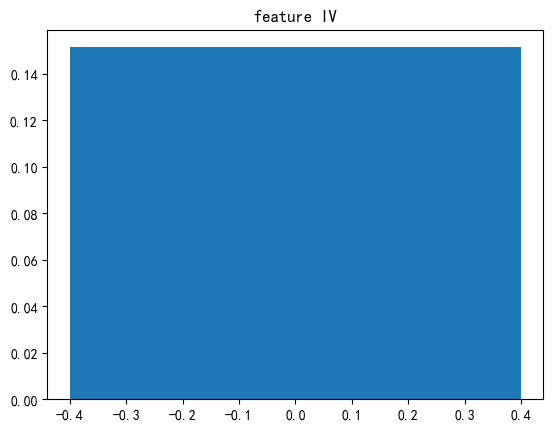

In [118]:
# （7）将变量IV值进行降序排列，方便后续挑选变量
iv_dict_sorted = sorted(iv_dict.items(), key=lambda x: x[1], reverse=True)
iv_values = [i[1] for i in iv_dict_sorted]
iv_names = [i[0] for i in iv_dict_sorted]
plt.title('feature IV')
plt.bar(range(len(iv_values)),iv_values)
iv_dict_sorted

In [119]:
# （9）test 整理
short_list = []
for iv in iv_dict_sorted:
    short_list.append(iv[0])
short_list_ori = [i.replace('_Bin', '') for i in short_list]
len(short_list_ori)

test = test[fixed_var + short_list_ori]
test.shape
test[:1]

# short_list_ori = v_list
# short_list = v_list + '_Bin'


1

KeyError: "['极瞳分'] not in index"

In [ ]:
# （10）test Bin映射

for var in short_list_ori:
    if -1111 not in set(test[var]) and -999 not in set(test[var]):
        test[var + '_Bin'] = test[var].map(lambda x: AssignBin_me(x, continous_merged_dict[var]))
        del test[var]
    else:
        test[var + '_Bin'] = test[var].map(lambda x: AssignBin_me(x, continous_merged_dict[var],[-1111, -999]))
        del test[var]

print("- Time consumed: %s seconds" % int(time.time() - start_time))

test.shape

- Time consumed: 46 seconds


(6465, 10)

In [ ]:
# （11）计算PSI
# regroup_test = pd.DataFrame()
# testData_1 = test.copy()
# testData_1.shape

# for col in short_list:
#     total = testData_1.groupby([col])['y'].count()
#     total = pd.DataFrame({'total': total})
#     total.reset_index(level=0, inplace=True)
#     total.rename(columns = {col:'Bin'}, inplace=True)
#     total['var'] = col
    
#     regroup_test = pd.concat([regroup_test, total])
    
# regroup_all_train = regroup_all[regroup_all['var'].isin(short_list)]
# regroup_psi = regroup_all_train.merge(regroup_test, on = ['var', 'Bin'], how = 'outer', suffixes = ('_x', '_y'))
# regroup_psi = regroup_psi[['var', 'Bin', 'total_x', 'total_y']]
# total_x = trainData_kf_Bin_1.shape[0]
# total_y = testData_1.shape[0]
# regroup_psi['psi'] = (regroup_psi['total_y']*1.0 / total_y - regroup_psi['total_x']*1.0 / total_x)*np.log((regroup_psi['total_y']*1.0 / total_y)/(regroup_psi['total_x']*1.0 / total_x))
# regroup_psi.groupby(['var']).agg({'psi': 'sum'})

In [ ]:
# （12）相关性诊断
# train[['afz_v2_score']].corr()
# test[v_list].corr()

In [ ]:
# （13）统计
# 乐吧分析
# view_m = '2024-08'
# view_m = '2025-03'
# conditions_2 = (df_analy_ks.search_time == view_m)
df_analy_ks = pd.concat([trainData_kf_Bin_1, test])
# df_analy_ks.search_time.value_counts()
# conditions_2 = ((df_analy_ks.下单日期 >= '2024-01-01') & (df_analy_ks.下单日期 <= '2024-06-30'))
# pd.pivot_table(df_analy_ks[conditions_2],index='v1_1_1_Bin',columns='y_fraud_fpd7',values='order_number',aggfunc='count')
# pd.pivot_table(df_analy_ks[conditions_2],index='v1_1_1_Bin',columns='y_fraud_mob3dpd7',values='order_number',aggfunc='count')
# pd.pivot_table(df_analy_ks[conditions_2],index='v1_1_1_Bin',columns='y_credit_mob3dpd30',values='order_number',aggfunc='count')
# pd.pivot_table(df_analy_ks[conditions_2],index='v1_1_1_Bin',columns='y_credit_mob6dpd30',values='order_number',aggfunc='count')
# conditions_2 = ((df_analy_ks.下单日期 >= '2024-07-01') & (df_analy_ks.下单日期 <= '2024-07-31'))
# pd.pivot_table(df_analy_ks[conditions_2],index='v1_1_1_Bin',columns='y_fraud_fpd7',values='order_number',aggfunc='count')
# pd.pivot_table(df_analy_ks[conditions_2],index='v1_1_1_Bin',columns='y_fraud_mob3dpd7',values='order_number',aggfunc='count')
# pd.pivot_table(df_analy_ks[conditions_2],index='v1_1_1_Bin',columns='y_credit_mob3dpd30',values='order_number',aggfunc='count')
# pd.pivot_table(df_analy_ks[conditions_2],index='v1_1_1_Bin',columns='y_credit_mob6dpd30',values='order_number',aggfunc='count')
# conditions_2 = ((df_analy_ks.下单日期 >= '2024-08-01') & (df_analy_ks.下单日期 <= '2024-08-31'))
# pd.pivot_table(df_analy_ks[conditions_2],index='v1_1_1_Bin',columns='y_fraud_fpd7',values='order_number',aggfunc='count')
# pd.pivot_table(df_analy_ks[conditions_2],index='v1_1_1_Bin',columns='y_fraud_mob3dpd7',values='order_number',aggfunc='count')
# pd.pivot_table(df_analy_ks[conditions_2],index='v1_1_1_Bin',columns='y_credit_mob3dpd30',values='order_number',aggfunc='count')
# pd.pivot_table(df_analy_ks[conditions_2],index='v1_1_1_Bin',columns='y_credit_mob6dpd30',values='order_number',aggfunc='count')
# conditions_2 = ((df_analy_ks.下单日期 >= '2024-09-01') & (df_analy_ks.下单日期 <= '2024-09-30'))
# pd.pivot_table(df_analy_ks[conditions_2],index='v1_1_1_Bin',columns='y_fraud_fpd7',values='order_number',aggfunc='count')
# pd.pivot_table(df_analy_ks[conditions_2],index='v1_1_1_Bin',columns='y_fraud_mob3dpd7',values='order_number',aggfunc='count')
# pd.pivot_table(df_analy_ks[conditions_2],index='v1_1_1_Bin',columns='y_credit_mob3dpd30',values='order_number',aggfunc='count')
# pd.pivot_table(df_analy_ks[conditions_2],index='v1_1_1_Bin',columns='y_credit_mob6dpd30',values='order_number',aggfunc='count')
# conditions_2 = ((df_analy_ks.下单日期 >= '2024-10-01') & (df_analy_ks.下单日期 <= '2024-10-31'))
# pd.pivot_table(df_analy_ks[conditions_2],index='v1_1_1_Bin',columns='y_fraud_fpd7',values='order_number',aggfunc='count')
# pd.pivot_table(df_analy_ks[conditions_2],index='v1_1_1_Bin',columns='y_fraud_mob3dpd7',values='order_number',aggfunc='count')
# pd.pivot_table(df_analy_ks[conditions_2],index='v1_1_1_Bin',columns='y_credit_mob3dpd30',values='order_number',aggfunc='count')
# pd.pivot_table(df_analy_ks[conditions_2],index='v1_1_1_Bin',columns='y_credit_mob6dpd30',values='order_number',aggfunc='count')
# conditions_2 = ((df_analy_ks.下单日期 >= '2024-11-01') & (df_analy_ks.下单日期 <= '2024-11-30'))
# pd.pivot_table(df_analy_ks[conditions_2],index='v1_1_1_Bin',columns='y_fraud_fpd7',values='order_number',aggfunc='count')
# pd.pivot_table(df_analy_ks[conditions_2],index='v1_1_1_Bin',columns='y_fraud_mob3dpd7',values='order_number',aggfunc='count')
# pd.pivot_table(df_analy_ks[conditions_2],index='v1_1_1_Bin',columns='y_credit_mob3dpd30',values='order_number',aggfunc='count')
# pd.pivot_table(df_analy_ks[conditions_2],index='v1_1_1_Bin',columns='y_credit_mob6dpd30',values='order_number',aggfunc='count')
# conditions_2 = ((df_analy_ks.下单日期 >= '2024-12-01') & (df_analy_ks.下单日期 <= '2024-12-31'))
# pd.pivot_table(df_analy_ks[conditions_2],index='v1_1_1_Bin',columns='y_fraud_fpd7',values='order_number',aggfunc='count')
# pd.pivot_table(df_analy_ks[conditions_2],index='v1_1_1_Bin',columns='y_fraud_mob3dpd7',values='order_number',aggfunc='count')
# pd.pivot_table(df_analy_ks[conditions_2],index='v1_1_1_Bin',columns='y_credit_mob3dpd30',values='order_number',aggfunc='count')
# pd.pivot_table(df_analy_ks[conditions_2],index='v1_1_1_Bin',columns='y_credit_mob6dpd30',values='order_number',aggfunc='count')
# conditions_2 = ((df_analy_ks.下单日期 >= '2025-01-01') & (df_analy_ks.下单日期 <= '2025-01-31'))
# pd.pivot_table(df_analy_ks[conditions_2],index='v1_1_1_Bin',columns='y_fraud_fpd7',values='order_number',aggfunc='count')
# pd.pivot_table(df_analy_ks[conditions_2],index='v1_1_1_Bin',columns='y_fraud_mob3dpd7',values='order_number',aggfunc='count')
# pd.pivot_table(df_analy_ks[conditions_2],index='v1_1_1_Bin',columns='y_credit_mob3dpd30',values='order_number',aggfunc='count')
# pd.pivot_table(df_analy_ks[conditions_2],index='v1_1_1_Bin',columns='y_credit_mob6dpd30',values='order_number',aggfunc='count')
# conditions_2 = ((df_analy_ks.下单日期 >= '2025-02-01') & (df_analy_ks.下单日期 <= '2025-02-28'))
# pd.pivot_table(df_analy_ks[conditions_2],index='v1_1_1_Bin',columns='y_fraud_fpd7',values='order_number',aggfunc='count')
# pd.pivot_table(df_analy_ks[conditions_2],index='v1_1_1_Bin',columns='y_fraud_mob3dpd7',values='order_number',aggfunc='count')
# pd.pivot_table(df_analy_ks[conditions_2],index='v1_1_1_Bin',columns='y_credit_mob3dpd30',values='order_number',aggfunc='count')
# pd.pivot_table(df_analy_ks[conditions_2],index='v1_1_1_Bin',columns='y_credit_mob6dpd30',values='order_number',aggfunc='count')
# conditions_2 = ((df_analy_ks.下单日期 >= '2025-03-01') & (df_analy_ks.下单日期 <= '2025-03-31'))
# pd.pivot_table(df_analy_ks[conditions_2],index='v1_1_1_Bin',columns='y_fraud_fpd7',values='order_number',aggfunc='count')
# pd.pivot_table(df_analy_ks[conditions_2],index='v1_1_1_Bin',columns='y_fraud_mob3dpd7',values='order_number',aggfunc='count')
# pd.pivot_table(df_analy_ks[conditions_2],index='v1_1_1_Bin',columns='y_credit_mob3dpd30',values='order_number',aggfunc='count')
# pd.pivot_table(df_analy_ks[conditions_2],index='v1_1_1_Bin',columns='y_credit_mob6dpd30',values='order_number',aggfunc='count')

In [ ]:
# conditions_2 = ((df_analy_ks.下单日期 >= '2024-01-01') & (df_analy_ks.下单日期 <= '2024-06-30'))
# pd.pivot_table(df_analy_ks[conditions_2],index='v2_2_4_Bin',columns='y_fraud_fpd7',values='order_number',aggfunc='count')
# pd.pivot_table(df_analy_ks[conditions_2],index='v2_2_4_Bin',columns='y_fraud_mob3dpd7',values='order_number',aggfunc='count')
# pd.pivot_table(df_analy_ks[conditions_2],index='v2_2_4_Bin',columns='y_credit_mob3dpd30',values='order_number',aggfunc='count')
# pd.pivot_table(df_analy_ks[conditions_2],index='v2_2_4_Bin',columns='y_credit_mob6dpd30',values='order_number',aggfunc='count')
# conditions_2 = ((df_analy_ks.下单日期 >= '2024-07-01') & (df_analy_ks.下单日期 <= '2024-07-31'))
# pd.pivot_table(df_analy_ks[conditions_2],index='v2_2_4_Bin',columns='y_fraud_fpd7',values='order_number',aggfunc='count')
# pd.pivot_table(df_analy_ks[conditions_2],index='v2_2_4_Bin',columns='y_fraud_mob3dpd7',values='order_number',aggfunc='count')
# pd.pivot_table(df_analy_ks[conditions_2],index='v2_2_4_Bin',columns='y_credit_mob3dpd30',values='order_number',aggfunc='count')
# pd.pivot_table(df_analy_ks[conditions_2],index='v2_2_4_Bin',columns='y_credit_mob6dpd30',values='order_number',aggfunc='count')
# conditions_2 = ((df_analy_ks.下单日期 >= '2024-08-01') & (df_analy_ks.下单日期 <= '2024-08-31'))
# pd.pivot_table(df_analy_ks[conditions_2],index='v2_2_4_Bin',columns='y_fraud_fpd7',values='order_number',aggfunc='count')
# pd.pivot_table(df_analy_ks[conditions_2],index='v2_2_4_Bin',columns='y_fraud_mob3dpd7',values='order_number',aggfunc='count')
# pd.pivot_table(df_analy_ks[conditions_2],index='v2_2_4_Bin',columns='y_credit_mob3dpd30',values='order_number',aggfunc='count')
# pd.pivot_table(df_analy_ks[conditions_2],index='v2_2_4_Bin',columns='y_credit_mob6dpd30',values='order_number',aggfunc='count')
# conditions_2 = ((df_analy_ks.下单日期 >= '2024-09-01') & (df_analy_ks.下单日期 <= '2024-09-30'))
# pd.pivot_table(df_analy_ks[conditions_2],index='v2_2_4_Bin',columns='y_fraud_fpd7',values='order_number',aggfunc='count')
# pd.pivot_table(df_analy_ks[conditions_2],index='v2_2_4_Bin',columns='y_fraud_mob3dpd7',values='order_number',aggfunc='count')
# pd.pivot_table(df_analy_ks[conditions_2],index='v2_2_4_Bin',columns='y_credit_mob3dpd30',values='order_number',aggfunc='count')
# pd.pivot_table(df_analy_ks[conditions_2],index='v2_2_4_Bin',columns='y_credit_mob6dpd30',values='order_number',aggfunc='count')
# conditions_2 = ((df_analy_ks.下单日期 >= '2024-10-01') & (df_analy_ks.下单日期 <= '2024-10-31'))
# pd.pivot_table(df_analy_ks[conditions_2],index='v2_2_4_Bin',columns='y_fraud_fpd7',values='order_number',aggfunc='count')
# pd.pivot_table(df_analy_ks[conditions_2],index='v2_2_4_Bin',columns='y_fraud_mob3dpd7',values='order_number',aggfunc='count')
# pd.pivot_table(df_analy_ks[conditions_2],index='v2_2_4_Bin',columns='y_credit_mob3dpd30',values='order_number',aggfunc='count')
# pd.pivot_table(df_analy_ks[conditions_2],index='v2_2_4_Bin',columns='y_credit_mob6dpd30',values='order_number',aggfunc='count')
# conditions_2 = ((df_analy_ks.下单日期 >= '2024-11-01') & (df_analy_ks.下单日期 <= '2024-11-30'))
# pd.pivot_table(df_analy_ks[conditions_2],index='v2_2_4_Bin',columns='y_fraud_fpd7',values='order_number',aggfunc='count')
# pd.pivot_table(df_analy_ks[conditions_2],index='v2_2_4_Bin',columns='y_fraud_mob3dpd7',values='order_number',aggfunc='count')
# pd.pivot_table(df_analy_ks[conditions_2],index='v2_2_4_Bin',columns='y_credit_mob3dpd30',values='order_number',aggfunc='count')
# pd.pivot_table(df_analy_ks[conditions_2],index='v2_2_4_Bin',columns='y_credit_mob6dpd30',values='order_number',aggfunc='count')
# conditions_2 = ((df_analy_ks.下单日期 >= '2024-12-01') & (df_analy_ks.下单日期 <= '2024-12-31'))
# pd.pivot_table(df_analy_ks[conditions_2],index='v2_2_4_Bin',columns='y_fraud_fpd7',values='order_number',aggfunc='count')
# pd.pivot_table(df_analy_ks[conditions_2],index='v2_2_4_Bin',columns='y_fraud_mob3dpd7',values='order_number',aggfunc='count')
# pd.pivot_table(df_analy_ks[conditions_2],index='v2_2_4_Bin',columns='y_credit_mob3dpd30',values='order_number',aggfunc='count')
# pd.pivot_table(df_analy_ks[conditions_2],index='v2_2_4_Bin',columns='y_credit_mob6dpd30',values='order_number',aggfunc='count')
# conditions_2 = ((df_analy_ks.下单日期 >= '2025-01-01') & (df_analy_ks.下单日期 <= '2025-01-31'))
# pd.pivot_table(df_analy_ks[conditions_2],index='v2_2_4_Bin',columns='y_fraud_fpd7',values='order_number',aggfunc='count')
# pd.pivot_table(df_analy_ks[conditions_2],index='v2_2_4_Bin',columns='y_fraud_mob3dpd7',values='order_number',aggfunc='count')
# pd.pivot_table(df_analy_ks[conditions_2],index='v2_2_4_Bin',columns='y_credit_mob3dpd30',values='order_number',aggfunc='count')
# pd.pivot_table(df_analy_ks[conditions_2],index='v2_2_4_Bin',columns='y_credit_mob6dpd30',values='order_number',aggfunc='count')
# conditions_2 = ((df_analy_ks.下单日期 >= '2025-02-01') & (df_analy_ks.下单日期 <= '2025-02-28'))
# pd.pivot_table(df_analy_ks[conditions_2],index='v2_2_4_Bin',columns='y_fraud_fpd7',values='order_number',aggfunc='count')
# pd.pivot_table(df_analy_ks[conditions_2],index='v2_2_4_Bin',columns='y_fraud_mob3dpd7',values='order_number',aggfunc='count')
# pd.pivot_table(df_analy_ks[conditions_2],index='v2_2_4_Bin',columns='y_credit_mob3dpd30',values='order_number',aggfunc='count')
# pd.pivot_table(df_analy_ks[conditions_2],index='v2_2_4_Bin',columns='y_credit_mob6dpd30',values='order_number',aggfunc='count')
# conditions_2 = ((df_analy_ks.下单日期 >= '2025-03-01') & (df_analy_ks.下单日期 <= '2025-03-31'))
# pd.pivot_table(df_analy_ks[conditions_2],index='v2_2_4_Bin',columns='y_fraud_fpd7',values='order_number',aggfunc='count')
# pd.pivot_table(df_analy_ks[conditions_2],index='v2_2_4_Bin',columns='y_fraud_mob3dpd7',values='order_number',aggfunc='count')
# pd.pivot_table(df_analy_ks[conditions_2],index='v2_2_4_Bin',columns='y_credit_mob3dpd30',values='order_number',aggfunc='count')
# pd.pivot_table(df_analy_ks[conditions_2],index='v2_2_4_Bin',columns='y_credit_mob6dpd30',values='order_number',aggfunc='count')

In [ ]:
# 蚁盾分3.0
# conditions_2 = ((df_analy_ks.下单日期 >= '2024-03-01') & (df_analy_ks.下单日期 <= '2024-06-30'))
# pd.pivot_table(df_analy_ks[conditions_2],index='afz_v2_score_Bin',columns='y_fraud_fpd7',values='order_number',aggfunc='count')
# pd.pivot_table(df_analy_ks[conditions_2],index='afz_v2_score_Bin',columns='y_fraud_mob3dpd7',values='order_number',aggfunc='count')
# pd.pivot_table(df_analy_ks[conditions_2],index='afz_v2_score_Bin',columns='y_credit_mob3dpd30',values='order_number',aggfunc='count')
# pd.pivot_table(df_analy_ks[conditions_2],index='afz_v2_score_Bin',columns='y_credit_mob6dpd30',values='order_number',aggfunc='count')
# conditions_2 = ((df_analy_ks.下单日期 >= '2024-07-01') & (df_analy_ks.下单日期 <= '2024-07-31'))
# pd.pivot_table(df_analy_ks[conditions_2],index='afz_v2_score_Bin',columns='y_fraud_fpd7',values='order_number',aggfunc='count')
# pd.pivot_table(df_analy_ks[conditions_2],index='afz_v2_score_Bin',columns='y_fraud_mob3dpd7',values='order_number',aggfunc='count')
# pd.pivot_table(df_analy_ks[conditions_2],index='afz_v2_score_Bin',columns='y_credit_mob3dpd30',values='order_number',aggfunc='count')
# pd.pivot_table(df_analy_ks[conditions_2],index='afz_v2_score_Bin',columns='y_credit_mob6dpd30',values='order_number',aggfunc='count')
# conditions_2 = ((df_analy_ks.下单日期 >= '2024-08-01') & (df_analy_ks.下单日期 <= '2024-08-31'))
# pd.pivot_table(df_analy_ks[conditions_2],index='afz_v2_score_Bin',columns='y_fraud_fpd7',values='order_number',aggfunc='count')
# pd.pivot_table(df_analy_ks[conditions_2],index='afz_v2_score_Bin',columns='y_fraud_mob3dpd7',values='order_number',aggfunc='count')
# pd.pivot_table(df_analy_ks[conditions_2],index='afz_v2_score_Bin',columns='y_credit_mob3dpd30',values='order_number',aggfunc='count')
# pd.pivot_table(df_analy_ks[conditions_2],index='afz_v2_score_Bin',columns='y_credit_mob6dpd30',values='order_number',aggfunc='count')
# conditions_2 = ((df_analy_ks.下单日期 >= '2024-09-01') & (df_analy_ks.下单日期 <= '2024-09-30'))
# pd.pivot_table(df_analy_ks[conditions_2],index='afz_v2_score_Bin',columns='y_fraud_fpd7',values='order_number',aggfunc='count')
# pd.pivot_table(df_analy_ks[conditions_2],index='afz_v2_score_Bin',columns='y_fraud_mob3dpd7',values='order_number',aggfunc='count')
# pd.pivot_table(df_analy_ks[conditions_2],index='afz_v2_score_Bin',columns='y_credit_mob3dpd30',values='order_number',aggfunc='count')
# pd.pivot_table(df_analy_ks[conditions_2],index='afz_v2_score_Bin',columns='y_credit_mob6dpd30',values='order_number',aggfunc='count')
# conditions_2 = ((df_analy_ks.下单日期 >= '2024-10-01') & (df_analy_ks.下单日期 <= '2024-10-31'))
# pd.pivot_table(df_analy_ks[conditions_2],index='afz_v2_score_Bin',columns='y_fraud_fpd7',values='order_number',aggfunc='count')
# pd.pivot_table(df_analy_ks[conditions_2],index='afz_v2_score_Bin',columns='y_fraud_mob3dpd7',values='order_number',aggfunc='count')
# pd.pivot_table(df_analy_ks[conditions_2],index='afz_v2_score_Bin',columns='y_credit_mob3dpd30',values='order_number',aggfunc='count')
# pd.pivot_table(df_analy_ks[conditions_2],index='afz_v2_score_Bin',columns='y_credit_mob6dpd30',values='order_number',aggfunc='count')
# conditions_2 = ((df_analy_ks.下单日期 >= '2024-11-01') & (df_analy_ks.下单日期 <= '2024-11-30'))
# pd.pivot_table(df_analy_ks[conditions_2],index='afz_v2_score_Bin',columns='y_fraud_fpd7',values='order_number',aggfunc='count')
# pd.pivot_table(df_analy_ks[conditions_2],index='afz_v2_score_Bin',columns='y_fraud_mob3dpd7',values='order_number',aggfunc='count')
# pd.pivot_table(df_analy_ks[conditions_2],index='afz_v2_score_Bin',columns='y_credit_mob3dpd30',values='order_number',aggfunc='count')
# pd.pivot_table(df_analy_ks[conditions_2],index='afz_v2_score_Bin',columns='y_credit_mob6dpd30',values='order_number',aggfunc='count')
# conditions_2 = ((df_analy_ks.下单日期 >= '2024-12-01') & (df_analy_ks.下单日期 <= '2024-12-31'))
# pd.pivot_table(df_analy_ks[conditions_2],index='afz_v2_score_Bin',columns='y_fraud_fpd7',values='order_number',aggfunc='count')
# pd.pivot_table(df_analy_ks[conditions_2],index='afz_v2_score_Bin',columns='y_fraud_mob3dpd7',values='order_number',aggfunc='count')
# pd.pivot_table(df_analy_ks[conditions_2],index='afz_v2_score_Bin',columns='y_credit_mob3dpd30',values='order_number',aggfunc='count')
# pd.pivot_table(df_analy_ks[conditions_2],index='afz_v2_score_Bin',columns='y_credit_mob6dpd30',values='order_number',aggfunc='count')
# conditions_2 = ((df_analy_ks.下单日期 >= '2025-01-01') & (df_analy_ks.下单日期 <= '2025-01-31'))
# pd.pivot_table(df_analy_ks[conditions_2],index='afz_v2_score_Bin',columns='y_fraud_fpd7',values='order_number',aggfunc='count')
# pd.pivot_table(df_analy_ks[conditions_2],index='afz_v2_score_Bin',columns='y_fraud_mob3dpd7',values='order_number',aggfunc='count')
# pd.pivot_table(df_analy_ks[conditions_2],index='afz_v2_score_Bin',columns='y_credit_mob3dpd30',values='order_number',aggfunc='count')
# pd.pivot_table(df_analy_ks[conditions_2],index='afz_v2_score_Bin',columns='y_credit_mob6dpd30',values='order_number',aggfunc='count')
# conditions_2 = ((df_analy_ks.下单日期 >= '2025-02-01') & (df_analy_ks.下单日期 <= '2025-02-28'))
# pd.pivot_table(df_analy_ks[conditions_2],index='afz_v2_score_Bin',columns='y_fraud_fpd7',values='order_number',aggfunc='count')
# pd.pivot_table(df_analy_ks[conditions_2],index='afz_v2_score_Bin',columns='y_fraud_mob3dpd7',values='order_number',aggfunc='count')
# pd.pivot_table(df_analy_ks[conditions_2],index='afz_v2_score_Bin',columns='y_credit_mob3dpd30',values='order_number',aggfunc='count')
# pd.pivot_table(df_analy_ks[conditions_2],index='afz_v2_score_Bin',columns='y_credit_mob6dpd30',values='order_number',aggfunc='count')
# conditions_2 = ((df_analy_ks.下单日期 >= '2025-03-01') & (df_analy_ks.下单日期 <= '2025-03-31'))
# pd.pivot_table(df_analy_ks[conditions_2],index='afz_v2_score_Bin',columns='y_fraud_fpd7',values='order_number',aggfunc='count')
# pd.pivot_table(df_analy_ks[conditions_2],index='afz_v2_score_Bin',columns='y_fraud_mob3dpd7',values='order_number',aggfunc='count')
# pd.pivot_table(df_analy_ks[conditions_2],index='afz_v2_score_Bin',columns='y_credit_mob3dpd30',values='order_number',aggfunc='count')
# pd.pivot_table(df_analy_ks[conditions_2],index='afz_v2_score_Bin',columns='y_credit_mob6dpd30',values='order_number',aggfunc='count')

In [ ]:
# # 极瞳分
# conditions_2 = ((df_jt.下单日期 >= '2024-07-01') & (df_jt.下单日期 <= '2024-07-31'))
# pd.pivot_table(df_jt[conditions_2],index='极瞳分_Bin',columns='y_fraud_fpd7',values='order_number',aggfunc='count')
# pd.pivot_table(df_jt[conditions_2],index='极瞳分_Bin',columns='y_fraud_mob3dpd7',values='order_number',aggfunc='count')
# pd.pivot_table(df_jt[conditions_2],index='极瞳分_Bin',columns='y_credit_mob3dpd30',values='order_number',aggfunc='count')
# pd.pivot_table(df_jt[conditions_2],index='极瞳分_Bin',columns='y_credit_mob6dpd30',values='order_number',aggfunc='count')
# conditions_2 = ((df_jt.下单日期 >= '2024-08-01') & (df_jt.下单日期 <= '2024-08-31'))
# pd.pivot_table(df_jt[conditions_2],index='极瞳分_Bin',columns='y_fraud_fpd7',values='order_number',aggfunc='count')
# pd.pivot_table(df_jt[conditions_2],index='极瞳分_Bin',columns='y_fraud_mob3dpd7',values='order_number',aggfunc='count')
# pd.pivot_table(df_jt[conditions_2],index='极瞳分_Bin',columns='y_credit_mob3dpd30',values='order_number',aggfunc='count')
# pd.pivot_table(df_jt[conditions_2],index='极瞳分_Bin',columns='y_credit_mob6dpd30',values='order_number',aggfunc='count')
# conditions_2 = ((df_jt.下单日期 >= '2024-09-01') & (df_jt.下单日期 <= '2024-09-30'))
# pd.pivot_table(df_jt[conditions_2],index='极瞳分_Bin',columns='y_fraud_fpd7',values='order_number',aggfunc='count')
# pd.pivot_table(df_jt[conditions_2],index='极瞳分_Bin',columns='y_fraud_mob3dpd7',values='order_number',aggfunc='count')
# pd.pivot_table(df_jt[conditions_2],index='极瞳分_Bin',columns='y_credit_mob3dpd30',values='order_number',aggfunc='count')
# pd.pivot_table(df_jt[conditions_2],index='极瞳分_Bin',columns='y_credit_mob6dpd30',values='order_number',aggfunc='count')
# conditions_2 = ((df_jt.下单日期 >= '2024-10-01') & (df_jt.下单日期 <= '2024-10-31'))
# pd.pivot_table(df_jt[conditions_2],index='极瞳分_Bin',columns='y_fraud_fpd7',values='order_number',aggfunc='count')
# pd.pivot_table(df_jt[conditions_2],index='极瞳分_Bin',columns='y_fraud_mob3dpd7',values='order_number',aggfunc='count')
# pd.pivot_table(df_jt[conditions_2],index='极瞳分_Bin',columns='y_credit_mob3dpd30',values='order_number',aggfunc='count')
# pd.pivot_table(df_jt[conditions_2],index='极瞳分_Bin',columns='y_credit_mob6dpd30',values='order_number',aggfunc='count')
# conditions_2 = ((df_jt.下单日期 >= '2024-11-01') & (df_jt.下单日期 <= '2024-11-30'))
# pd.pivot_table(df_jt[conditions_2],index='极瞳分_Bin',columns='y_fraud_fpd7',values='order_number',aggfunc='count')
# pd.pivot_table(df_jt[conditions_2],index='极瞳分_Bin',columns='y_fraud_mob3dpd7',values='order_number',aggfunc='count')
# pd.pivot_table(df_jt[conditions_2],index='极瞳分_Bin',columns='y_credit_mob3dpd30',values='order_number',aggfunc='count')
# pd.pivot_table(df_jt[conditions_2],index='极瞳分_Bin',columns='y_credit_mob6dpd30',values='order_number',aggfunc='count')
# conditions_2 = ((df_jt.下单日期 >= '2024-12-01') & (df_jt.下单日期 <= '2024-12-31'))
# pd.pivot_table(df_jt[conditions_2],index='极瞳分_Bin',columns='y_fraud_fpd7',values='order_number',aggfunc='count')
# pd.pivot_table(df_jt[conditions_2],index='极瞳分_Bin',columns='y_fraud_mob3dpd7',values='order_number',aggfunc='count')
# pd.pivot_table(df_jt[conditions_2],index='极瞳分_Bin',columns='y_credit_mob3dpd30',values='order_number',aggfunc='count')
# pd.pivot_table(df_jt[conditions_2],index='极瞳分_Bin',columns='y_credit_mob6dpd30',values='order_number',aggfunc='count')
# conditions_2 = ((df_jt.下单日期 >= '2025-01-01') & (df_jt.下单日期 <= '2025-01-31'))
# pd.pivot_table(df_jt[conditions_2],index='极瞳分_Bin',columns='y_fraud_fpd7',values='order_number',aggfunc='count')
# pd.pivot_table(df_jt[conditions_2],index='极瞳分_Bin',columns='y_fraud_mob3dpd7',values='order_number',aggfunc='count')
# pd.pivot_table(df_jt[conditions_2],index='极瞳分_Bin',columns='y_credit_mob3dpd30',values='order_number',aggfunc='count')
# pd.pivot_table(df_jt[conditions_2],index='极瞳分_Bin',columns='y_credit_mob6dpd30',values='order_number',aggfunc='count')
# conditions_2 = ((df_jt.下单日期 >= '2025-02-01') & (df_jt.下单日期 <= '2025-02-28'))
# pd.pivot_table(df_jt[conditions_2],index='极瞳分_Bin',columns='y_fraud_fpd7',values='order_number',aggfunc='count')
# pd.pivot_table(df_jt[conditions_2],index='极瞳分_Bin',columns='y_fraud_mob3dpd7',values='order_number',aggfunc='count')
# pd.pivot_table(df_jt[conditions_2],index='极瞳分_Bin',columns='y_credit_mob3dpd30',values='order_number',aggfunc='count')
# pd.pivot_table(df_jt[conditions_2],index='极瞳分_Bin',columns='y_credit_mob6dpd30',values='order_number',aggfunc='count')
# conditions_2 = ((df_jt.下单日期 >= '2025-03-01') & (df_jt.下单日期 <= '2025-03-31'))
# pd.pivot_table(df_jt[conditions_2],index='极瞳分_Bin',columns='y_fraud_fpd7',values='order_number',aggfunc='count')
# pd.pivot_table(df_jt[conditions_2],index='极瞳分_Bin',columns='y_fraud_mob3dpd7',values='order_number',aggfunc='count')
# pd.pivot_table(df_jt[conditions_2],index='极瞳分_Bin',columns='y_credit_mob3dpd30',values='order_number',aggfunc='count')
# pd.pivot_table(df_jt[conditions_2],index='极瞳分_Bin',columns='y_credit_mob6dpd30',values='order_number',aggfunc='count')

y_fraud_fpd7,0,1
极瞳分_Bin,,
"1.(599.95,inf]",47.0,8.0
"2.(599.64,599.95]",56.0,8.0
"3.(591.96,599.64]",263.0,15.0
"4.(471.45,591.96]",877.0,25.0
"5.(400.2,471.45]",528.0,8.0
"6.[0,400.2]",217.0,1.0
7.-999,7.0,NaN


y_fraud_mob3dpd7,0,1
极瞳分_Bin,,
"1.(599.95,inf]",40.0,15.0
"2.(599.64,599.95]",42.0,22.0
"3.(591.96,599.64]",222.0,56.0
"4.(471.45,591.96]",799.0,103.0
"5.(400.2,471.45]",493.0,43.0
"6.[0,400.2]",205.0,13.0
7.-999,7.0,NaN


y_credit_mob3dpd30,0,1
极瞳分_Bin,,
"1.(599.95,inf]",42.0,13.0
"2.(599.64,599.95]",48.0,16.0
"3.(591.96,599.64]",241.0,37.0
"4.(471.45,591.96]",831.0,71.0
"5.(400.2,471.45]",507.0,29.0
"6.[0,400.2]",209.0,9.0
7.-999,7.0,NaN


y_credit_mob6dpd30,0,1
极瞳分_Bin,,
"1.(599.95,inf]",32,23
"2.(599.64,599.95]",44,20
"3.(591.96,599.64]",210,68
"4.(471.45,591.96]",742,160
"5.(400.2,471.45]",452,84
"6.[0,400.2]",202,16
7.-999,6,1


y_fraud_fpd7,0,1
极瞳分_Bin,,
"1.(599.95,inf]",57,6
"2.(599.64,599.95]",79,8
"3.(591.96,599.64]",273,21
"4.(471.45,591.96]",879,43
"5.(400.2,471.45]",610,18
"6.[0,400.2]",241,8
7.-999,2,1


y_fraud_mob3dpd7,0,1
极瞳分_Bin,,
"1.(599.95,inf]",47,16
"2.(599.64,599.95]",64,23
"3.(591.96,599.64]",238,56
"4.(471.45,591.96]",780,142
"5.(400.2,471.45]",567,61
"6.[0,400.2]",225,24
7.-999,2,1


y_credit_mob3dpd30,0,1
极瞳分_Bin,,
"1.(599.95,inf]",50,13
"2.(599.64,599.95]",70,17
"3.(591.96,599.64]",251,43
"4.(471.45,591.96]",815,107
"5.(400.2,471.45]",585,43
"6.[0,400.2]",230,19
7.-999,2,1


y_credit_mob6dpd30,0,1
极瞳分_Bin,,
"1.(599.95,inf]",47,16
"2.(599.64,599.95]",59,28
"3.(591.96,599.64]",211,83
"4.(471.45,591.96]",718,204
"5.(400.2,471.45]",532,96
"6.[0,400.2]",215,34
7.-999,1,2


y_fraud_fpd7,0,1
极瞳分_Bin,,
"1.(599.95,inf]",88,8
"2.(599.64,599.95]",94,9
"3.(591.96,599.64]",398,18
"4.(471.45,591.96]",1050,41
"5.(400.2,471.45]",618,19
"6.[0,400.2]",249,2


y_fraud_mob3dpd7,0,1
极瞳分_Bin,,
"1.(599.95,inf]",73,23
"2.(599.64,599.95]",80,23
"3.(591.96,599.64]",347,69
"4.(471.45,591.96]",952,139
"5.(400.2,471.45]",564,73
"6.[0,400.2]",235,16


y_credit_mob3dpd30,0,1
极瞳分_Bin,,
"1.(599.95,inf]",77,19
"2.(599.64,599.95]",88,15
"3.(591.96,599.64]",363,53
"4.(471.45,591.96]",990,101
"5.(400.2,471.45]",584,53
"6.[0,400.2]",239,12


y_credit_mob6dpd30,0,1
极瞳分_Bin,,
"1.(599.95,inf]",63,33
"2.(599.64,599.95]",70,33
"3.(591.96,599.64]",310,106
"4.(471.45,591.96]",891,200
"5.(400.2,471.45]",531,106
"6.[0,400.2]",231,20


y_fraud_fpd7,0,1
极瞳分_Bin,,
"1.(599.95,inf]",56.0,8.0
"2.(599.64,599.95]",67.0,3.0
"3.(591.96,599.64]",288.0,8.0
"4.(471.45,591.96]",649.0,20.0
"5.(400.2,471.45]",345.0,3.0
"6.[0,400.2]",153.0,3.0
7.-999,2.0,NaN


y_fraud_mob3dpd7,0,1
极瞳分_Bin,,
"1.(599.95,inf]",48.0,16.0
"2.(599.64,599.95]",55.0,15.0
"3.(591.96,599.64]",241.0,55.0
"4.(471.45,591.96]",580.0,89.0
"5.(400.2,471.45]",319.0,29.0
"6.[0,400.2]",144.0,12.0
7.-999,2.0,NaN


y_credit_mob3dpd30,0,1
极瞳分_Bin,,
"1.(599.95,inf]",52.0,12.0
"2.(599.64,599.95]",60.0,10.0
"3.(591.96,599.64]",254.0,42.0
"4.(471.45,591.96]",608.0,61.0
"5.(400.2,471.45]",329.0,19.0
"6.[0,400.2]",147.0,9.0
7.-999,2.0,NaN


y_credit_mob6dpd30,0,1
极瞳分_Bin,,
"1.(599.95,inf]",46.0,18.0
"2.(599.64,599.95]",53.0,17.0
"3.(591.96,599.64]",226.0,70.0
"4.(471.45,591.96]",546.0,123.0
"5.(400.2,471.45]",304.0,44.0
"6.[0,400.2]",139.0,17.0
7.-999,2.0,NaN


y_fraud_fpd7,0,1
极瞳分_Bin,,
"1.(599.95,inf]",79.0,5.0
"2.(599.64,599.95]",112.0,5.0
"3.(591.96,599.64]",416.0,14.0
"4.(471.45,591.96]",1023.0,22.0
"5.(400.2,471.45]",544.0,17.0
"6.[0,400.2]",240.0,NaN
7.-999,2.0,1.0


y_fraud_mob3dpd7,0,1
极瞳分_Bin,,
"1.(599.95,inf]",64,20
"2.(599.64,599.95]",94,23
"3.(591.96,599.64]",370,60
"4.(471.45,591.96]",903,142
"5.(400.2,471.45]",510,51
"6.[0,400.2]",225,15
7.-999,2,1


y_credit_mob3dpd30,0,1
极瞳分_Bin,,
"1.(599.95,inf]",68,16
"2.(599.64,599.95]",99,18
"3.(591.96,599.64]",385,45
"4.(471.45,591.96]",949,96
"5.(400.2,471.45]",528,33
"6.[0,400.2]",228,12
7.-999,2,1


y_credit_mob6dpd30,0,1
极瞳分_Bin,,
"1.(599.95,inf]",60,24
"2.(599.64,599.95]",90,27
"3.(591.96,599.64]",354,76
"4.(471.45,591.96]",881,164
"5.(400.2,471.45]",499,62
"6.[0,400.2]",218,22
7.-999,2,1


y_fraud_fpd7,0,1
极瞳分_Bin,,
"1.(599.95,inf]",115.0,8.0
"2.(599.64,599.95]",166.0,9.0
"3.(591.96,599.64]",550.0,31.0
"4.(471.45,591.96]",1279.0,38.0
"5.(400.2,471.45]",675.0,11.0
"6.[0,400.2]",281.0,3.0
7.-999,3.0,NaN


y_fraud_mob3dpd7,0,1
极瞳分_Bin,,
"1.(599.95,inf]",98.0,25.0
"2.(599.64,599.95]",142.0,33.0
"3.(591.96,599.64]",486.0,95.0
"4.(471.45,591.96]",1157.0,160.0
"5.(400.2,471.45]",618.0,68.0
"6.[0,400.2]",270.0,14.0
7.-999,3.0,NaN


y_credit_mob3dpd30,0,1
极瞳分_Bin,,
"1.(599.95,inf]",103.0,20.0
"2.(599.64,599.95]",149.0,26.0
"3.(591.96,599.64]",505.0,76.0
"4.(471.45,591.96]",1194.0,123.0
"5.(400.2,471.45]",643.0,43.0
"6.[0,400.2]",276.0,8.0
7.-999,3.0,NaN


y_credit_mob6dpd30,0,1
极瞳分_Bin,,
"1.(599.95,inf]",100,23
"2.(599.64,599.95]",144,31
"3.(591.96,599.64]",486,95
"4.(471.45,591.96]",1158,159
"5.(400.2,471.45]",625,61
"6.[0,400.2]",270,14
7.-999,2,1


y_fraud_fpd7,0,1
极瞳分_Bin,,
"1.(599.95,inf]",64.0,4.0
"2.(599.64,599.95]",74.0,4.0
"3.(591.96,599.64]",257.0,6.0
"4.(471.45,591.96]",722.0,20.0
"5.(400.2,471.45]",398.0,4.0
"6.[0,400.2]",199.0,4.0
7.-999,1.0,NaN


y_fraud_mob3dpd7,0,1
极瞳分_Bin,,
"1.(599.95,inf]",55.0,13.0
"2.(599.64,599.95]",63.0,15.0
"3.(591.96,599.64]",232.0,31.0
"4.(471.45,591.96]",632.0,110.0
"5.(400.2,471.45]",360.0,42.0
"6.[0,400.2]",190.0,13.0
7.-999,1.0,NaN


y_credit_mob3dpd30,0,1
极瞳分_Bin,,
"1.(599.95,inf]",59.0,9.0
"2.(599.64,599.95]",68.0,10.0
"3.(591.96,599.64]",242.0,21.0
"4.(471.45,591.96]",673.0,69.0
"5.(400.2,471.45]",380.0,22.0
"6.[0,400.2]",195.0,8.0
7.-999,1.0,NaN


y_credit_mob6dpd30,0,1
极瞳分_Bin,,
"1.(599.95,inf]",59.0,9.0
"2.(599.64,599.95]",68.0,10.0
"3.(591.96,599.64]",242.0,21.0
"4.(471.45,591.96]",673.0,69.0
"5.(400.2,471.45]",380.0,22.0
"6.[0,400.2]",195.0,8.0
7.-999,1.0,NaN


y_fraud_fpd7,0,1
极瞳分_Bin,,
"1.(599.95,inf]",59.0,8.0
"2.(599.64,599.95]",88.0,5.0
"3.(591.96,599.64]",291.0,19.0
"4.(471.45,591.96]",761.0,40.0
"5.(400.2,471.45]",482.0,14.0
"6.[0,400.2]",203.0,4.0
7.-999,1.0,NaN


y_fraud_mob3dpd7,0,1
极瞳分_Bin,,
"1.(599.95,inf]",55.0,12.0
"2.(599.64,599.95]",81.0,12.0
"3.(591.96,599.64]",265.0,45.0
"4.(471.45,591.96]",711.0,90.0
"5.(400.2,471.45]",452.0,44.0
"6.[0,400.2]",192.0,15.0
7.-999,1.0,NaN


y_credit_mob3dpd30,0,1
极瞳分_Bin,,
"1.(599.95,inf]",61.0,6.0
"2.(599.64,599.95]",87.0,6.0
"3.(591.96,599.64]",287.0,23.0
"4.(471.45,591.96]",760.0,41.0
"5.(400.2,471.45]",485.0,11.0
"6.[0,400.2]",202.0,5.0
7.-999,1.0,NaN


y_credit_mob6dpd30,0,1
极瞳分_Bin,,
"1.(599.95,inf]",61.0,6.0
"2.(599.64,599.95]",87.0,6.0
"3.(591.96,599.64]",287.0,23.0
"4.(471.45,591.96]",760.0,41.0
"5.(400.2,471.45]",485.0,11.0
"6.[0,400.2]",202.0,5.0
7.-999,1.0,NaN


y_fraud_fpd7,0,1
极瞳分_Bin,,
"1.(599.95,inf]",75,6
"2.(599.64,599.95]",83,13
"3.(591.96,599.64]",400,25
"4.(471.45,591.96]",1068,66
"5.(400.2,471.45]",680,25
"6.[0,400.2]",285,4
7.-999,2,1


y_fraud_mob3dpd7,0,1
极瞳分_Bin,,
"1.(599.95,inf]",73,8
"2.(599.64,599.95]",80,16
"3.(591.96,599.64]",386,39
"4.(471.45,591.96]",1051,83
"5.(400.2,471.45]",667,38
"6.[0,400.2]",283,6
7.-999,2,1


y_credit_mob3dpd30,0,1
极瞳分_Bin,,
"1.(599.95,inf]",78.0,3.0
"2.(599.64,599.95]",94.0,2.0
"3.(591.96,599.64]",421.0,4.0
"4.(471.45,591.96]",1113.0,21.0
"5.(400.2,471.45]",702.0,3.0
"6.[0,400.2]",288.0,1.0
7.-999,3.0,NaN


y_credit_mob6dpd30,0,1
极瞳分_Bin,,
"1.(599.95,inf]",78.0,3.0
"2.(599.64,599.95]",94.0,2.0
"3.(591.96,599.64]",421.0,4.0
"4.(471.45,591.96]",1113.0,21.0
"5.(400.2,471.45]",702.0,3.0
"6.[0,400.2]",288.0,1.0
7.-999,3.0,NaN
